In [1]:
from functions import *

2024-11-18 15:13:29.452932: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-18 15:13:29.473543: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-18 15:13:29.479899: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-18 15:13:29.496403: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-18 15:13:30.656747: W tensorflow/compiler/tf2

The goal of this notebook is to analyze the difference between air temperature via satellital images and in-situ measuring devices

In [2]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import os
import rasterio
import glob
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import pandas as pd
import geopandas as gpd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pyproj
from geopandas.tools import sjoin
from shapely.geometry import Point
import requests
from scipy.stats import ks_2samp
from sklearn.preprocessing import OneHotEncoder
import time
from datetime import datetime
from collections import Counter

## Visualization of clean images

Load data returning metadata

In [3]:
def load_data(dir_paths, W=None, rgb=[], show=None):
    data = {}
    time_slots = []
    metas_l = []
    for i, path in enumerate(dir_paths):
        image_files = os.listdir(path)

        # Filter out files without a valid date in the filename
        valid_image_files = [img for img in image_files if extract_year_month_from_filename(img) is not None]

        # Sort the valid image files by year and month extracted from the filename
        valid_image_files = sorted(valid_image_files, key=lambda x: extract_year_month_from_filename(x))
        
        times = []
        imgs_data = []
        metas = []
        for img_file in valid_image_files:
            imagen_path = os.path.join(path, img_file)
            try:
                img_data, meta = load_raster(imagen_path, rgb[i])  # Load raster data
    
                if W:  # Resize the image if W is provided
                    img_data = resize_image(img_data, W, W)
    
                imgs_data.append(img_data)
                times.append(extract_year_month_from_filename(img_file))
                metas.append(meta)
            except:
                pass
            
        data[path] = np.array(imgs_data)
        time_slots.append(times)
        metas_l.append(metas)

    return data, time_slots,metas_l

In [11]:
# Set variables
source_folder = '../data/external/raster_masks'
rivers = {}
source_path = '../data/preprocessed/'
data_paths = ['lst','ndvi','slope', 'direction','altitude']#,'wt','ndvi','slope', 'discharge','masked']#,'slope', 'discharge']#, 'ndvi', 'wt', 'masked','discharge', 'slope']#, 'wt_interpolated']
dir_paths = [os.path.join(source_path,p) for p in data_paths]
all_dir_paths = {k:[] for k in data_paths}    
total_data = {}
total_times = {}
complete_rivers = []
filter_river = None
W=128
time_split = True
total_metas = {}

# Load rivers
for subdir, dirs, files in os.walk(source_folder):
    for i,file in enumerate(files):
        r,m = load_raster(os.path.join(subdir, file), False)
        name = file.split('.')[0].split('bw_')[-1]
        rivers[name] = r

# Load input paths
for i,dir_p in enumerate(dir_paths):
    if data_paths[i] != 'discharge' and data_paths[i] != 'slope' and data_paths[i] != 'altitude':
        imgs_per_river = Counter()
    for subdir, dirs,files in os.walk(dir_p):
        if subdir != dir_p and not subdir.endswith('masked') and not subdir.endswith('.ipynb_checkpoints'): 
            all_dir_paths[data_paths[i]].append(subdir)
        elif subdir.endswith('masked') and 'masked' in data_paths:
            all_dir_paths['masked'].append(subdir)
        elif dir_p.endswith('altitude'):
            all_dir_paths[data_paths[i]].extend(files)


        


In [12]:
# Load input data

for k,v in all_dir_paths.items():
    if filter_river != None:
        v = [v[i] for i in filter_river]
    
    if k != 'direction' and k != 'slope' and k != 'altitude':
        if k == 'lst' or k == 'masked':
            list_rgb = [True]*len(v)
        else:
            list_rgb = [False]*len(v)
            
        data, times, metas = load_data(v,W,list_rgb)
        if k!='masked':
            labels = []
            for ki,value in data.items():
                labels+=[ki.split('/')[-1]]*len(value)
        
        data_values = [np.array(img) for sublist in list(data.values()) for img in sublist]
        times_list = [t for sublist in times for t in sublist]
        
        metas_list = [m for sublist in metas for m in sublist]
        
   
        if time_split:
            dates = [datetime.strptime(date, '%Y-%m') for date in times_list]
            pairs = sorted(zip(dates, data_values, labels, metas_list), key=lambda x: x[0])
            sorted_dates, data_values, labels, metas = zip(*pairs)
            times_list = [date.strftime('%Y-%m') for date in sorted_dates]
            
        total_data[k] = np.array(data_values)
        total_times[k] = times_list
        total_metas[k] = metas
        print(k,':' ,total_data[k].shape)

lst : (1487, 128, 128, 3)
ndvi : (1487, 128, 128)


In [13]:
for k,v in all_dir_paths.items():
    total = []
    metas = []
    if k == 'direction' or k == 'slope' or k == 'altitude':
        imgss = {}
        for i,lab in enumerate(labels):
            for file in v:
                if lab == file.split('/')[-1] or lab == file.split('/')[-1].split('discharge_')[-1].split('.')[0]:#or lab == file.split('.')[0] 
                    
                    if lab not in imgss:
                        if k != 'altitude':
                            print('passo perque', lab, 'està a', file.split('/')[-1].split('discharge_')[-1].split('.')[0])
                            file_path = os.path.join(file,os.listdir(file)[0])
                        else:
                            file_path = os.path.join('../data/preprocessed/altitude', file)
                        print(file_path)
                        r,m = load_raster(file_path, False)
                        var = resize_image(r, W,W)
                        imgss[lab] = var
                    else:
                        var = imgss[lab]
                           
                    total.append(var)
                    metas.append(m)
                        
        total_data[k] = np.array(total)
        total_metas[k] = metas
        print(k, np.array(total).shape)

passo perque cell_13 està a cell_13
../data/preprocessed/slope/cell_13/cell_13.tif
passo perque cell_62 està a cell_62
../data/preprocessed/slope/cell_62/cell_62.tif
passo perque cell_65 està a cell_65
../data/preprocessed/slope/cell_65/cell_65.tif
passo perque cell_52 està a cell_52
../data/preprocessed/slope/cell_52/cell_52.tif
passo perque cell_53 està a cell_53
../data/preprocessed/slope/cell_53/cell_53.tif
passo perque cell_35 està a cell_35
../data/preprocessed/slope/cell_35/cell_35.tif
passo perque cell_34 està a cell_34
../data/preprocessed/slope/cell_34/cell_34.tif
passo perque cell_16 està a cell_16
../data/preprocessed/slope/cell_16/cell_16.tif
passo perque cell_43 està a cell_43
../data/preprocessed/slope/cell_43/cell_43.tif
passo perque cell_68 està a cell_68
../data/preprocessed/slope/cell_68/cell_68.tif
passo perque cell_28 està a cell_28
../data/preprocessed/slope/cell_28/cell_28.tif
passo perque cell_20 està a cell_20
../data/preprocessed/slope/cell_20/cell_20.tif
pass

#### Load rivers

In [7]:
import os
import fiona
import geopandas as gpd
from shapely.geometry import shape
import matplotlib.pyplot as plt
from shapely.ops import unary_union

river_cells = {}
output_directory = '../data/external/shp/river_cells_oficial'#_10x10km#river_cells'
a=0

for i,riv in enumerate(os.listdir(output_directory)):
    # Check if the file is a shapefile
    try:
        if riv.endswith('.shp'):
            a+=1
            print(f"Processing file: {riv}")
            river = gpd.read_file(os.path.join(output_directory, riv))
            river = river.to_crs("EPSG:4326")
            river_cells[riv.split('station_')[-1].split('.')[0]] = river
            print('Added', riv.split('station_')[-1].split('.')[0])

    except Exception as e:
        print(f"Error processing file: {riv}",e)
        pass

Processing file: station_cell_37.shp
Added cell_37
Processing file: station_cell_8.shp
Added cell_8
Processing file: station_cell_33.shp
Added cell_33
Processing file: station_cell_9.shp
Added cell_9
Processing file: station_cell_42.shp
Added cell_42
Processing file: station_cell_78.shp
Added cell_78
Processing file: station_cell_6.shp
Added cell_6
Processing file: station_cell_46.shp
Added cell_46
Processing file: station_cell_31.shp
Added cell_31
Processing file: station_cell_59.shp
Added cell_59
Processing file: station_cell_63.shp
Added cell_63
Processing file: station_cell_11.shp
Added cell_11
Processing file: station_cell_36.shp
Added cell_36
Processing file: station_cell_65.shp
Added cell_65
Processing file: station_cell_56.shp
Added cell_56
Processing file: station_cell_12.shp
Added cell_12
Processing file: station_cell_72.shp
Added cell_72
Processing file: station_cell_24.shp
Added cell_24
Processing file: station_cell_38.shp
Added cell_38
Processing file: station_cell_80.shp


#### Show variables and check bounds

/tmp/ipykernel_2698593/190390133.py:23: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  gdf.plot(ax=ax[0],color='none')


AttributeError: 'str' object has no attribute 'plot'

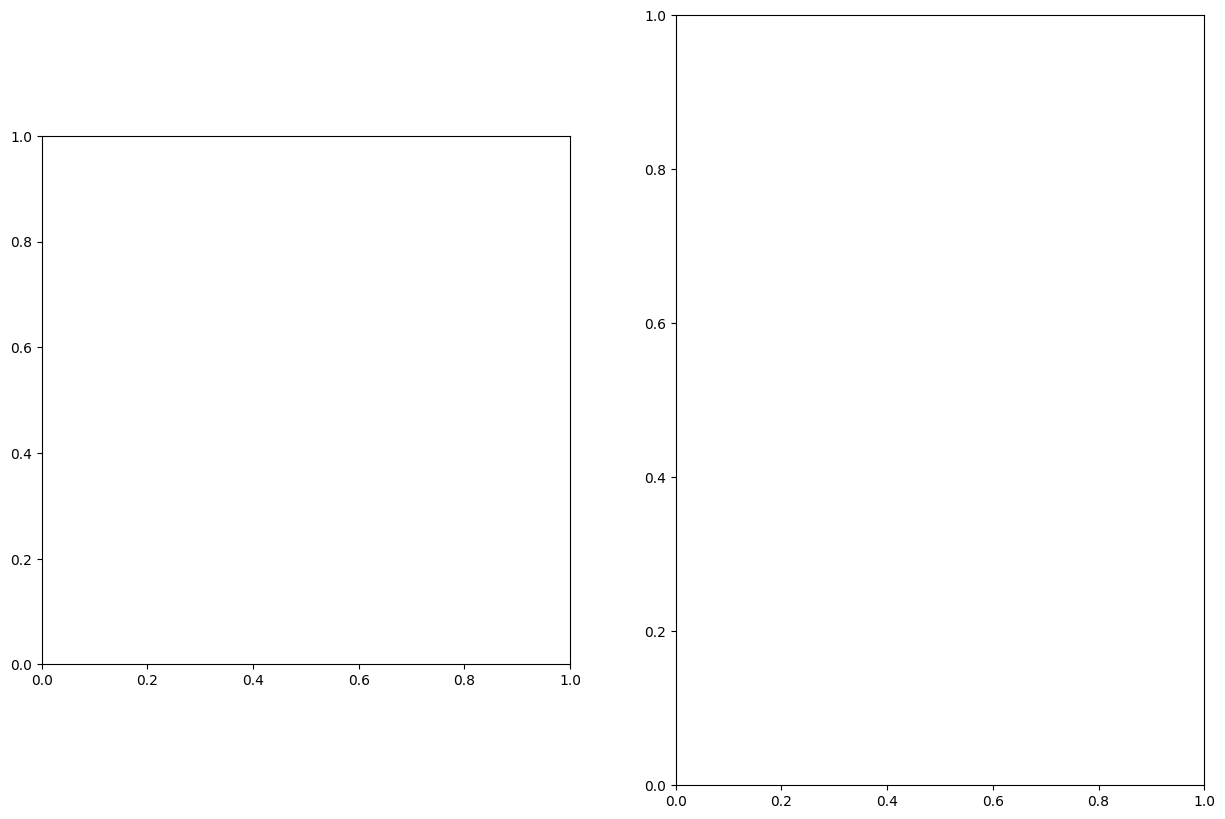

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
from shapely.geometry import box

source_dir='../data/raw/ndvi'
# Example list of images (replace this with your actual images)
# For demonstration, let's create random images
bounding_boxes = []
cells1=[]
for subdir, dirs, files in os.walk(source_dir):
    if subdir != source_dir and os.listdir(subdir)!=[]:
        file = os.listdir(subdir)[0]
        if file.endswith('tif'):
            r,m = load_raster(os.path.join(subdir,file),False)
            bounds = m.bounds
            bounding_boxes.append(box(*bounds))
            cells1.append(subdir.split('/')[-1])

fig,ax= plt.subplots(1,2,figsize=(15,10))
gdf =  gpd.GeoDataFrame(geometry=bounding_boxes, crs="EPSG:3426")             
# Add labels and 
gdf.plot(ax=ax[0],color='none')
riv.plot(ax=ax[0],edgecolor='blue')

source_dir='../data/raw/lst'
bounding_boxes2 = []
cells2=[]
for subdir, dirs, files in os.walk(source_dir):
    if subdir != source_dir and os.listdir(subdir)!=[]:
        file = os.listdir(subdir)[0]
        if file.endswith('tiff'):
            r,m = load_raster(os.path.join(subdir,file))
            bounds = m.bounds
            bounding_boxes2.append(box(*bounds))
            cells2.append(subdir.split('/')[-1])

gdf =  gpd.GeoDataFrame(geometry=bounding_boxes2, crs="EPSG:3426")             
# Add labels and 
gdf.plot(ax=ax[1],color='none')
riv.plot(ax=ax[1],edgecolor='blue')

NameError: name 'bounding_boxes2' is not defined

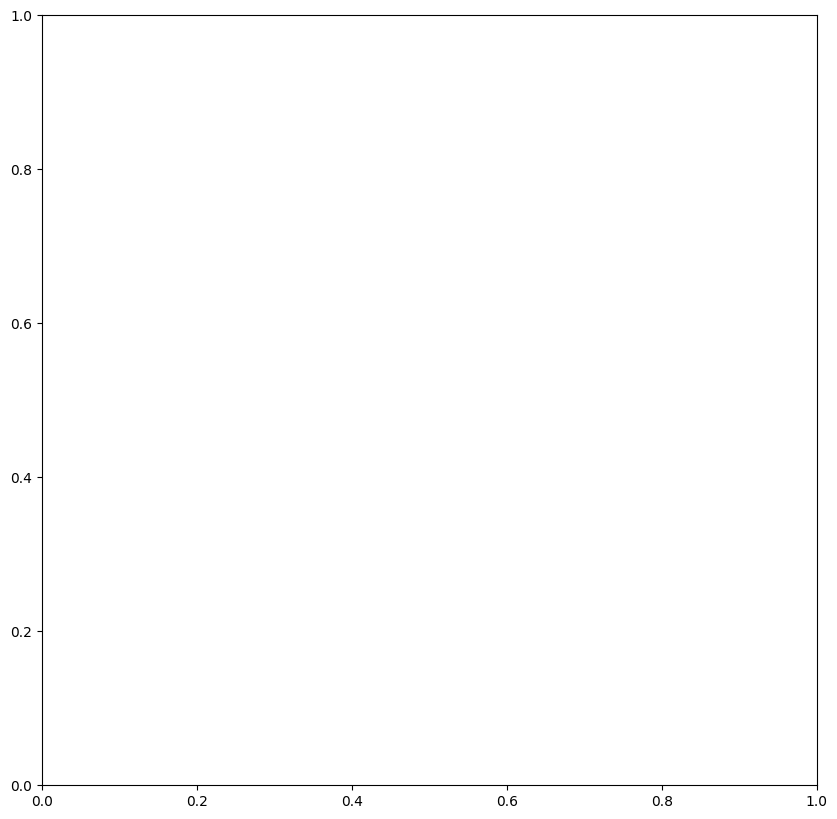

In [10]:
from shapely.geometry import Polygon
from matplotlib.patches import Polygon as mplPolygon

fig, ax = plt.subplots(figsize=(10, 10))
list1=bounding_boxes
list2=bounding_boxes2
# Iterate through each bounding box in list1
# Iterate through each polygon in list1
for i,poly1 in enumerate(list1):
    # Check for intersections with each polygon in list2
    for j,poly2 in enumerate(list2):
        #if poly1.intersects(poly2):
        if np.allclose(np.array(poly1.bounds), np.array(poly2.bounds), atol=1e-3):
        #if poly1.bounds == poly2.bounds:
            # Plot poly1
            print("Intersecting:", cells1[i], cells2[j]) 
            
            mpl_poly1 = mplPolygon(list(poly1.exterior.coords), edgecolor='blue', facecolor='none', linewidth=2)
            ax.add_patch(mpl_poly1)

            # Plot poly2
            mpl_poly2 = mplPolygon(list(poly2.exterior.coords), edgecolor='red', facecolor='none', linewidth=2)
            ax.add_patch(mpl_poly2)

# Set plot limits based on all polygons
all_polys = list1 + list2
all_x = [point[0] for poly in all_polys for point in poly.exterior.coords]
all_y = [point[1] for poly in all_polys for point in poly.exterior.coords]
ax.set_xlim(min(all_x), max(all_x))
ax.set_ylim(min(all_y), max(all_y))

# Customize plot
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Intersecting Bounding Boxes")
plt.grid(visible=True)
plt.show()

In [8]:
from pyproj import Transformer

def equal_coordenates(crs_2056, crs_wgs84, bounds_2056, bounds_wgs84):
    transformer = Transformer.from_crs(crs_2056, crs_wgs84, always_xy=True)
    minx, miny = transformer.transform(bounds_2056.left, bounds_2056.bottom)
    maxx, maxy = transformer.transform(bounds_2056.right, bounds_2056.top)
    # Transformed bounding box in WGS84
    transformed_bounds = (minx, miny, maxx, maxy)
    print('Transformed_bounds',transformed_bounds)

    # Original WGS84 bounds for comparison
    original_bounds_wgs84 = (bounds_wgs84.left, bounds_wgs84.bottom, bounds_wgs84.right, bounds_wgs84.top)
    
    # Set a tolerance for floating point comparisons
    tolerance = 0.1
    is_equal = all(
        abs(transformed_bounds[i] - original_bounds_wgs84[i]) < tolerance
        for i in range(4)
    )
    return is_equal

Index: 1, Label: cell_62
LST and NDVI bounds match: True
LST bounds and river cell bounds match: [ True  True  True  True]
NDVI bounds and river cell bounds match: [ True  True  True  True]
LST bounds: BoundingBox(left=8.978356199850882, bottom=47.03707716527338, right=9.165507305767568, top=47.16503901975482) LST CRS: EPSG:4326
NDVI bounds: BoundingBox(left=8.978356199850882, bottom=47.03707716527338, right=9.165507305767568, top=47.16503901975482) NDVI CRS: EPSG:4326
River cell bounds: [ 8.9783562  47.03707717  9.16550731 47.16503902]
Transformed_bounds (8.978343550219416, 47.039649846331486, 9.16585855831068, 47.16246740418259)
Discharge bounds match: True
Transformed_bounds (8.978343550219416, 47.039649846331486, 9.16585855831068, 47.16246740418259)
Slope bounds match: True
Transformed_bounds (9.048560891907297, 47.08574269664795, 9.095439607396594, 47.11644711220829)
Altitude bounds match: True


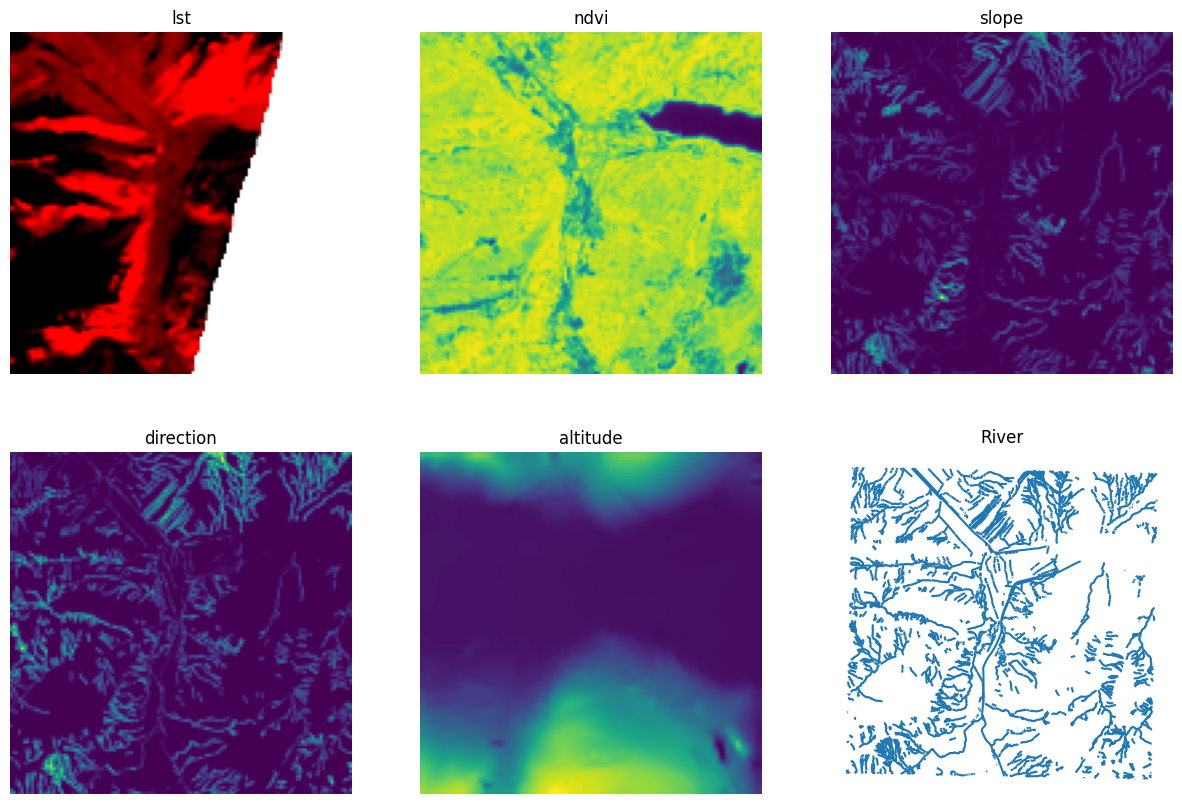



Index: 2, Label: cell_65
LST and NDVI bounds match: True
LST bounds and river cell bounds match: [ True  True  True  True]
NDVI bounds and river cell bounds match: [ True  True  True  True]
LST bounds: BoundingBox(left=9.804606435757712, bottom=46.42525141212122, right=9.991692209425205, top=46.55453166273482) LST CRS: EPSG:4326
NDVI bounds: BoundingBox(left=9.804606435757712, bottom=46.42525141212122, right=9.991692209425205, top=46.55453166273482) NDVI CRS: EPSG:4326
River cell bounds: [ 9.80460644 46.42525141  9.99169221 46.55453166]
Transformed_bounds (9.804444646239947, 46.429141081242605, 9.991712508645506, 46.550616946848066)
Discharge bounds match: True
Transformed_bounds (9.804444646239947, 46.429141081242605, 9.991712508645506, 46.550616946848066)
Slope bounds match: True
Transformed_bounds (9.874571691335774, 46.47473076563457, 9.921388623288871, 46.50509975778261)
Altitude bounds match: True


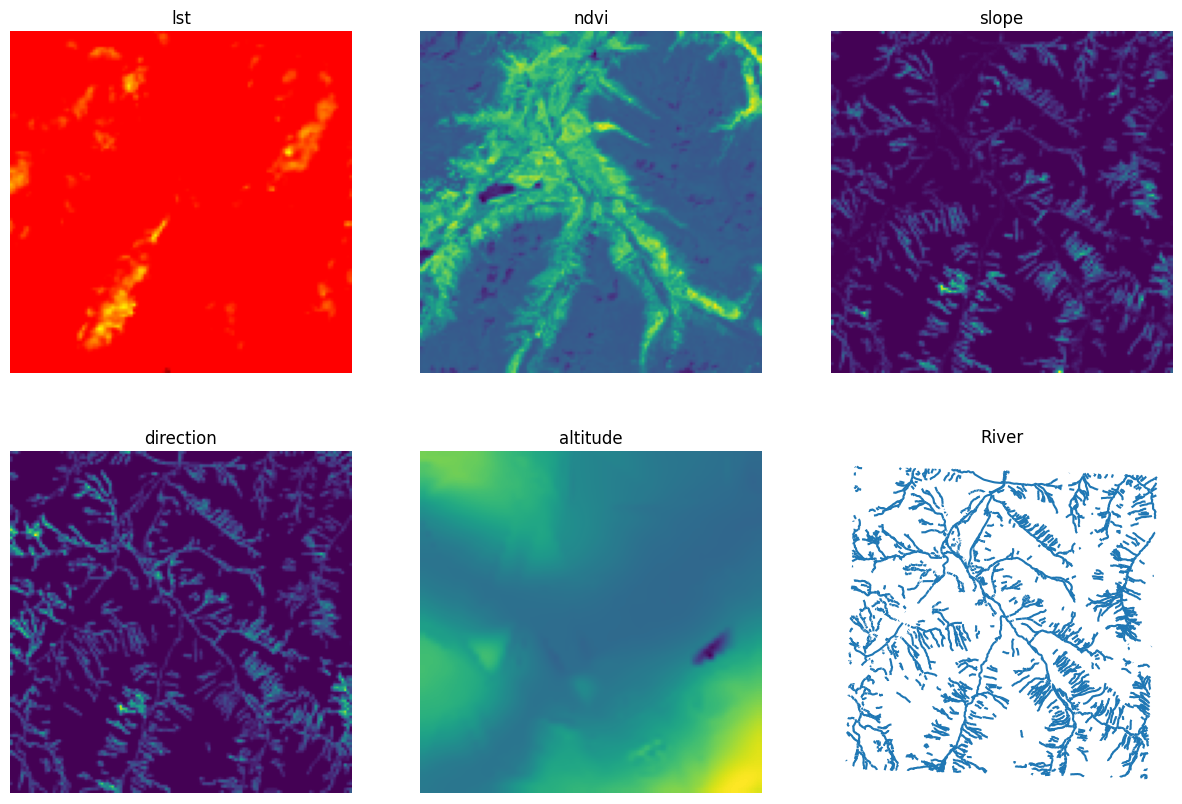



Index: 3, Label: cell_52
LST and NDVI bounds match: True
LST bounds and river cell bounds match: [ True  True  True  True]
NDVI bounds and river cell bounds match: [ True  True  True  True]
LST bounds: BoundingBox(left=8.205998956540387, bottom=46.991212305791684, right=8.391362218038234, top=47.11719475456272) LST CRS: EPSG:4326
NDVI bounds: BoundingBox(left=8.205998956540387, bottom=46.991212305791684, right=8.391362218038234, top=47.11719475456272) NDVI CRS: EPSG:4326
River cell bounds: [ 8.20599896 46.99121231  8.39136222 47.11719475]
Transformed_bounds (8.205930788571939, 46.99190834632833, 8.391372164859588, 47.115899303460345)
Discharge bounds match: True
Transformed_bounds (8.205930788571939, 46.99190834632833, 8.391372164859588, 47.115899303460345)
Slope bounds match: True
Transformed_bounds (8.275370757163882, 47.038440443166905, 8.321731063483723, 47.069438208345815)
Altitude bounds match: True


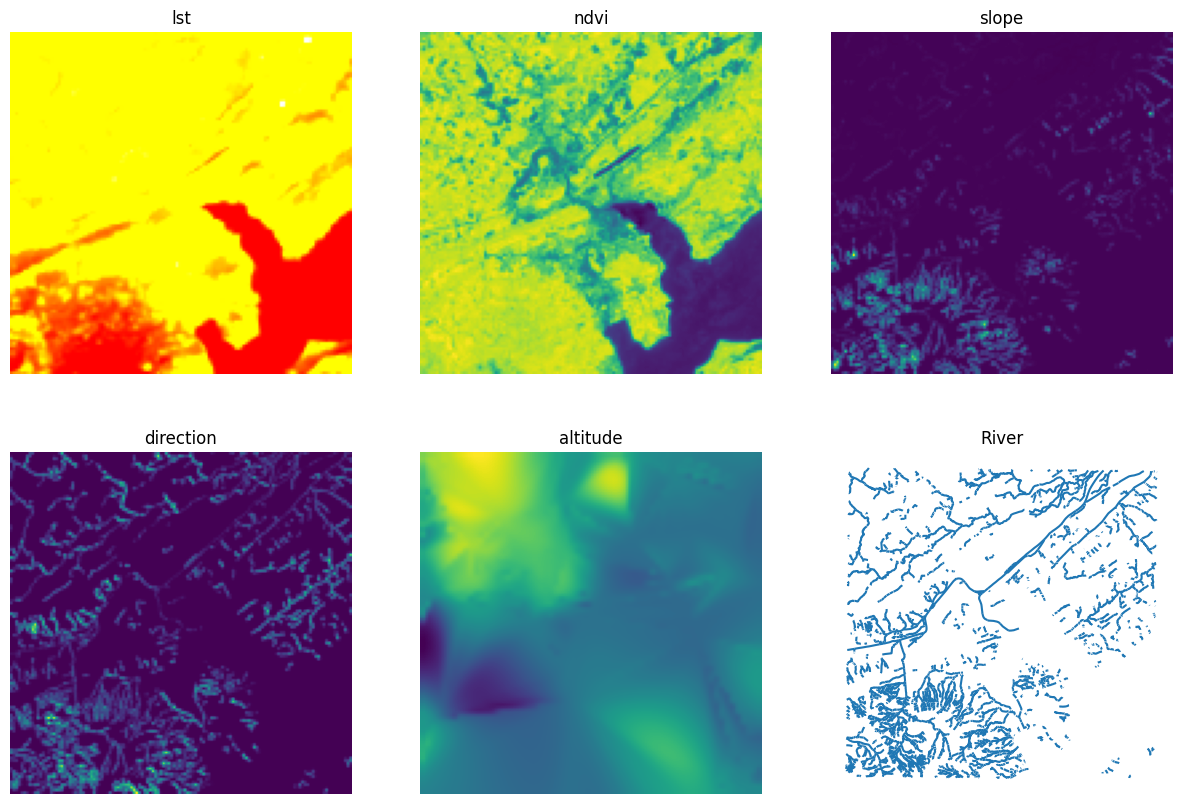



Index: 4, Label: cell_53
LST and NDVI bounds match: True
LST bounds and river cell bounds match: [ True  True  True  True]
NDVI bounds and river cell bounds match: [ True  True  True  True]
LST bounds: BoundingBox(left=7.520665292709111, bottom=46.701905467903806, right=7.703235719534087, top=46.827287872516955) LST CRS: EPSG:4326
NDVI bounds: BoundingBox(left=7.520665292709111, bottom=46.701905467903806, right=7.703235719534087, top=46.827287872516955) NDVI CRS: EPSG:4326
River cell bounds: [ 7.52066529 46.70190547  7.70323572 46.82728787]
Transformed_bounds (7.520662032645685, 46.70204226572795, 7.703332824579926, 46.82701623265498)
Discharge bounds match: True
Transformed_bounds (7.520662032645685, 46.70204226572795, 7.703332824579926, 46.82701623265498)
Slope bounds match: True
Transformed_bounds (7.58906428495801, 46.7489419791116, 7.634731944812374, 46.78018549633562)
Altitude bounds match: True


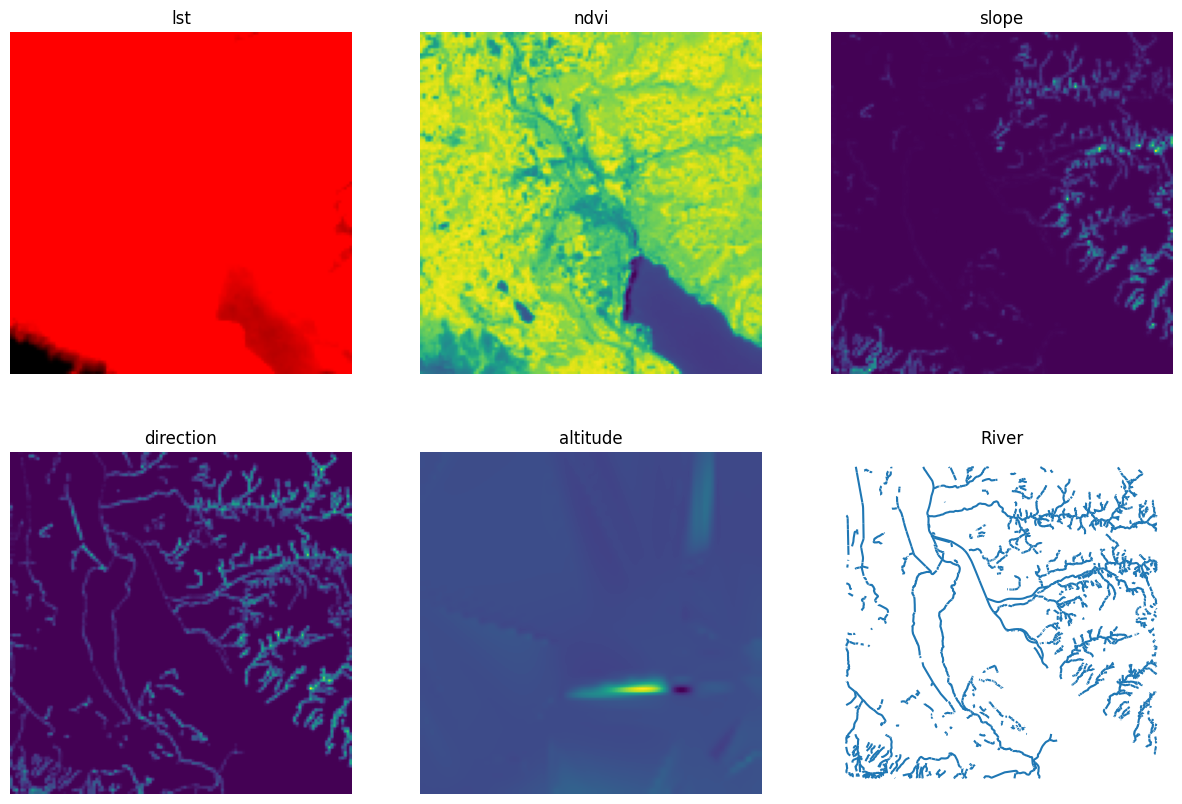

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Loop through the first 5 elements
for i in range(1,5):
    # Print label and check spatial bounds and CRS
    print(f"Index: {i}, Label: {labels[i]}")
    riu = labels[i]
    
    # Retrieve bounds and CRS for lst and ndvi
    lst_bounds = total_metas['lst'][i].bounds
    ndvi_bounds = total_metas['ndvi'][i].bounds
    
    # Compare bounds
    print("LST and NDVI bounds match:", lst_bounds == ndvi_bounds)
    print("LST bounds and river cell bounds match:", lst_bounds == river_cells[riu].total_bounds)
    print("NDVI bounds and river cell bounds match:", ndvi_bounds == river_cells[riu].total_bounds)
    
    # Print bounds and CRS details
    print("LST bounds:", lst_bounds, "LST CRS:", total_metas['lst'][i].crs)
    print("NDVI bounds:", ndvi_bounds, "NDVI CRS:", total_metas['ndvi'][i].crs)
    print("River cell bounds:", river_cells[riu].total_bounds)
    
    # Compare with additional datasets: discharge, slope, altitude
    crs_wgs84 = total_metas['lst'][i].crs
    bounds_wgs84 = ndvi_bounds

    # Discharge bounds and CRS comparison
    discharge_bounds = total_metas['direction'][i].bounds
    discharge_crs = total_metas['direction'][i].crs
    print("Discharge bounds match:", equal_coordenates(discharge_crs, crs_wgs84, discharge_bounds, bounds_wgs84))

    # Slope bounds and CRS comparison
    slope_bounds = total_metas['slope'][i].bounds
    slope_crs = total_metas['slope'][i].crs
    print("Slope bounds match:", equal_coordenates(slope_crs, crs_wgs84, slope_bounds, bounds_wgs84))

    # Altitude bounds and CRS comparison
    altitude_bounds = total_metas['altitude'][i].bounds
    altitude_crs = total_metas['altitude'][i].crs
    print("Altitude bounds match:", equal_coordenates(altitude_crs, crs_wgs84, altitude_bounds, bounds_wgs84))

    # Gather data for visualization
    data = [total_data[k][i] for k in data_paths]
    
    # Set up the figure and axes for a 2x3 grid
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))  # Adjust figsize as needed
    
    # Loop through each subplot and display the data
    for j, ax in enumerate(axs.flat):
        if j == 5:
            # Plot river cell for the last subplot
            river_cells[riu].plot(ax=ax)
        elif data_paths[j] == 'lst':
            # Plot LST data with clipping
            ax.imshow(np.clip(data[j] * (6 / 255), 0, 1), cmap='viridis')
        else:
            # Plot other data without clipping
            ax.imshow(data[j], cmap='viridis')
        
        # Set title and turn off axis for a cleaner look
        ax.set_title(f"{data_paths[j]}" if j != 5 else 'River')
        ax.axis("off")

    # Show the plot
    plt.show()
    
    # Print a separator for clarity between iterations
    print("\n" + "="*40 + "\n")


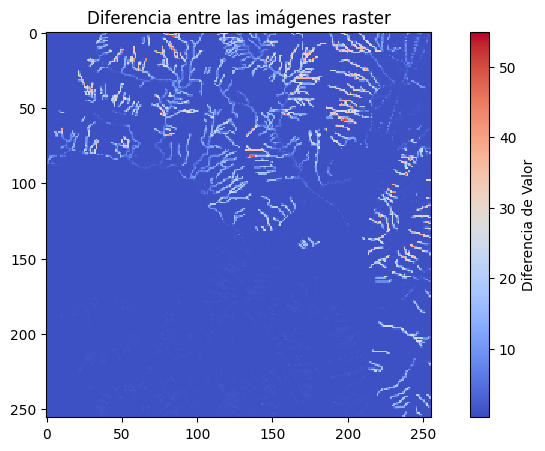

Diferencia media: 2.2251631334062836
Diferencia máxima: 54.93754728568479
Diferencia mínima: 0.2475143074989321


In [57]:
r1,m1=load_raster('../data/preprocessed/slope/cell_24/cell_24.tif', False)
r1 = resize_image(r1, 256,256)

r2,m2=load_raster('../data/preprocessed/slope_test/cell_24.tif', False)
r2 = np.where(np.isnan(r2), 0.0, r2)
if r1.shape == r2.shape:
    # Calcular la diferencia
    diff = r1 - r2
    
    # Configurar visualización de la diferencia
    plt.figure(figsize=(10, 5))
    plt.imshow(diff, cmap="coolwarm", interpolation="none")
    plt.colorbar(label="Diferencia de Valor")
    plt.title("Diferencia entre las imágenes raster")
    plt.show()
    
    # Opcional: Calcular estadísticas de la diferencia
    print("Diferencia media:", np.mean(diff))
    print("Diferencia máxima:", np.max(diff))
    print("Diferencia mínima:", np.min(diff))
else:
    print("Las imágenes no tienen las mismas dimensiones y no pueden compararse directamente.")

## Statistical comparison

### Landsat and air stations (interpolated with le boiron shp)

Load data

In [29]:
# Path to the folder with the cell shapefiles
cells_folder_path = "../data/external/shp/cleaned_cells"

# Create an empty GeoDataFrame to store cells that intersect the river
intersecting_cells = gpd.GeoDataFrame()

for file in os.listdir(cells_folder_path):
    if file.endswith(".shp"):
        # Load the cell shapefile
        cell = gpd.read_file(os.path.join(cells_folder_path, file))
        
        # Check if the cell intersects with the river
        if cell.intersects(shp_boiron, align = True).any():
            print('Trobada', file)
            # If there is an intersection, add the cell to the intersecting cells GeoDataFrame
            intersecting_cells = pd.concat([intersecting_cells, cell], ignore_index=True)

Trobada rivers_grid_cell_82.shp


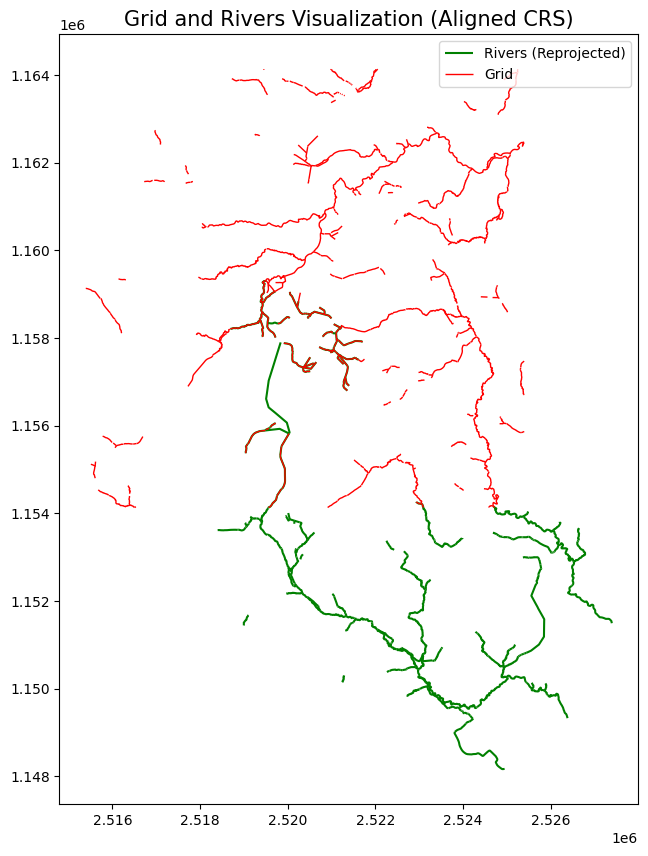

In [32]:

def visualize_grid(grid_shapefile, background_shapefile):#,boiron):
    # Load the grid shapefile (in EPSG:2056)
    grid = gpd.read_file(grid_shapefile)

    # Load the background shapefile (rivers) in EPSG:3035
    background = gpd.read_file(background_shapefile)

    # Reproject the background (rivers) to match the grid CRS (EPSG:2056)
    background_reprojected = background.to_crs(grid.crs)

    # Create a plot
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot the reprojected background (rivers)
    background_reprojected.plot(ax=ax, color='green',facecolor="none", edgecolor='black', label='Rivers (Reprojected)')

    # Plot the grid on the same axis
    grid.plot(ax=ax, facecolor="none", edgecolor="red", linewidth=1, label='Grid')

    #boiron.plot(ax=ax, facecolor="none", edgecolor="green", linewidth=1, label='Grid')
    

    # Add title and legend
    plt.title("Grid and Rivers Visualization (Aligned CRS)", fontsize=15)
    plt.legend()

    # Show the plot
    plt.show()

grid_shapefile = '../data/external/shp/cleaned_cells/rivers_grid_cell_82.shp'

# Optional: Path to a background shapefile (e.g., rivers)
background_shapefile = '../data/external/shp/Switzerland_shapefile'  # Set to None if you don't want a background
background_shapefile = '../data/external/shp/rivers/swissTLMboiron'
# Visualize the grid with a background
visualize_grid(grid_shapefile, background_shapefile)#,shp_boiron)


In [10]:
W = 256 # with 64 works LR
dir_paths = ['../data/preprocessed/lst/swissTLMboiron/','../data/raw/airtemp_interpolated']
data, time_slots = load_data(dir_paths,W,[True,False])
lst_data = data[dir_paths[0]]
airtemp_data = data[dir_paths[1]]

FileNotFoundError: [Errno 2] No such file or directory: '../data/preprocessed/lst/swissTLMboiron/'

In [70]:
indices = np.where(np.isin(time_slots[1], time_slots[0]))[0]

In [71]:
airtemp_data_filt = airtemp_data[indices]
airtemp_data_filt.shape

(18, 256, 256)

#### Visualize data

Doing 0
Time slot 2013-06


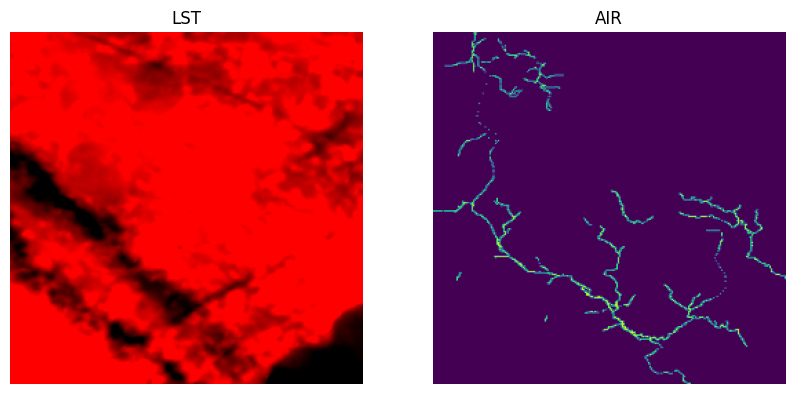

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)

Doing 1
Time slot 2014-02


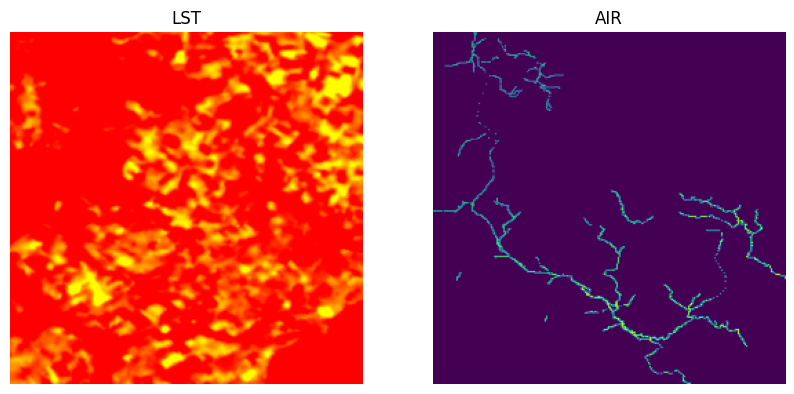

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)

Doing 2
Time slot 2014-03


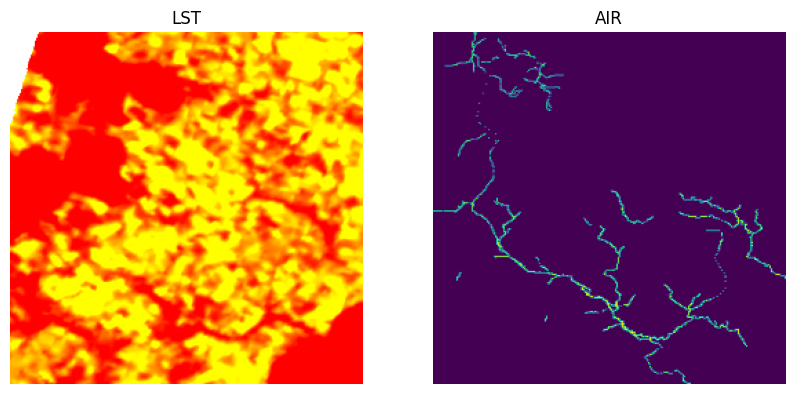

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)

Doing 3
Time slot 2014-05


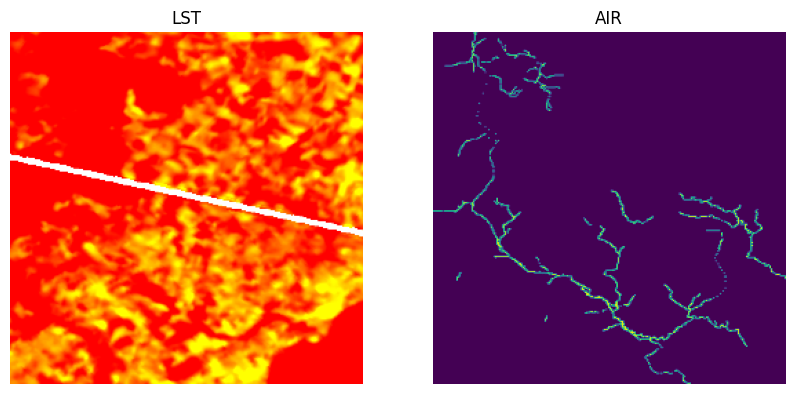

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)

Doing 4
Time slot 2014-11


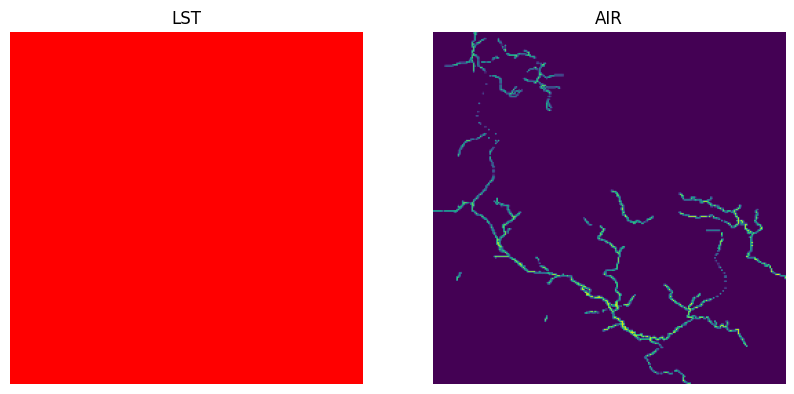

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)

Doing 5
Time slot 2015-03


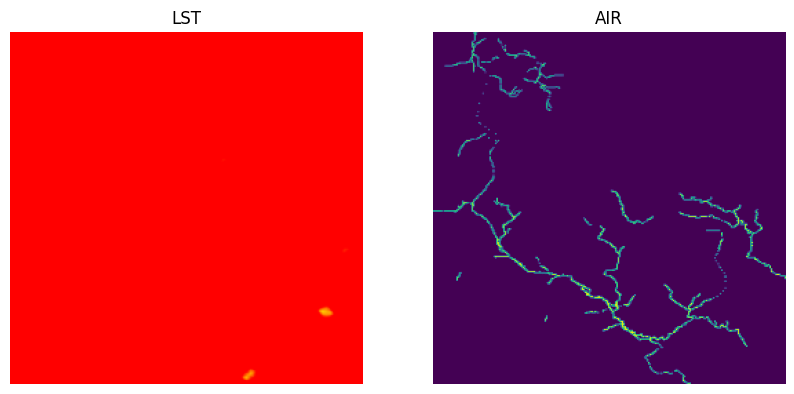

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)

Doing 6
Time slot 2015-04


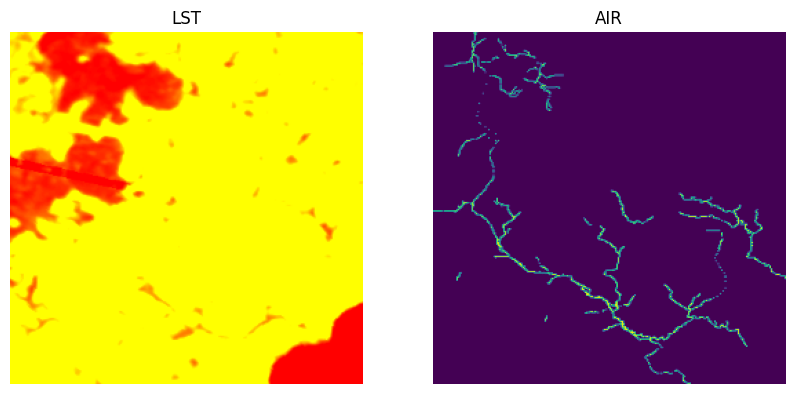

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)

Doing 7
Time slot 2015-07


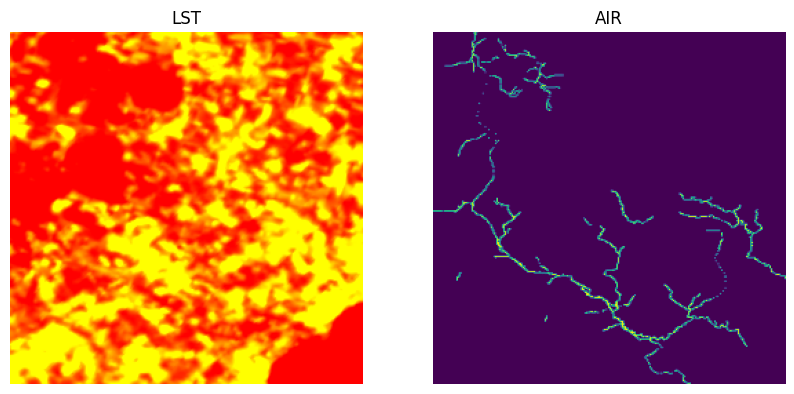

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)

Doing 8
Time slot 2016-05


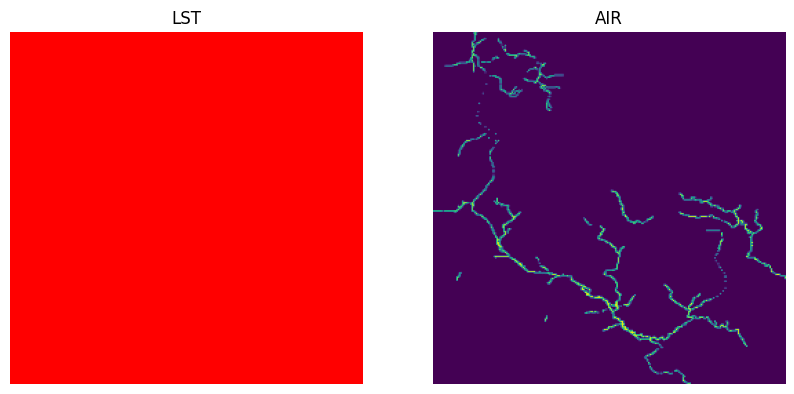

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)

Doing 9
Time slot 2016-08


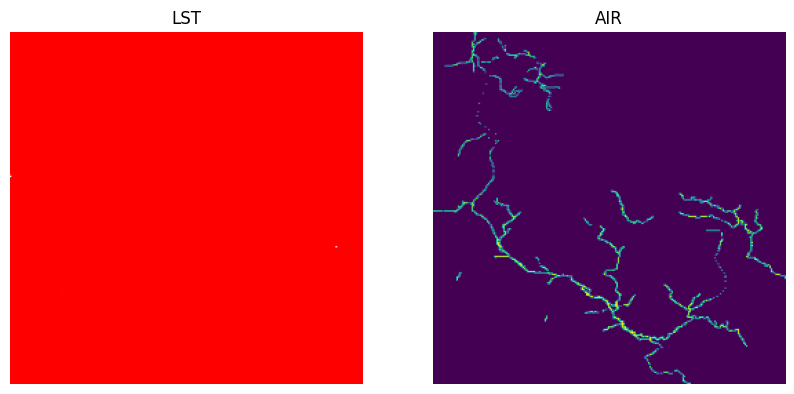

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)

Doing 10
Time slot 2016-09


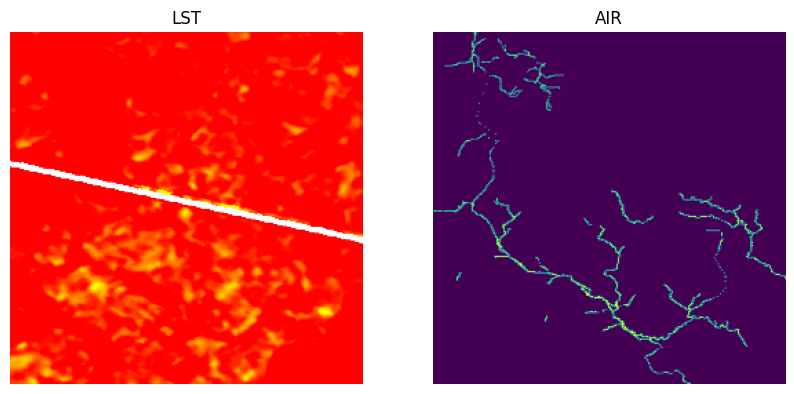

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)

Doing 11
Time slot 2017-01


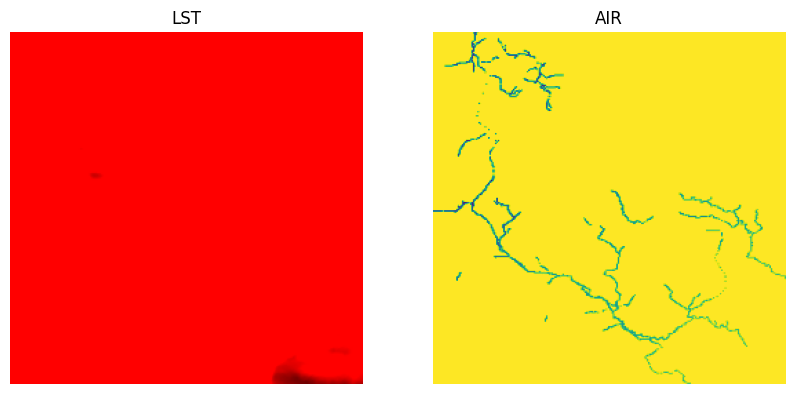

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)

Doing 12
Time slot 2017-06


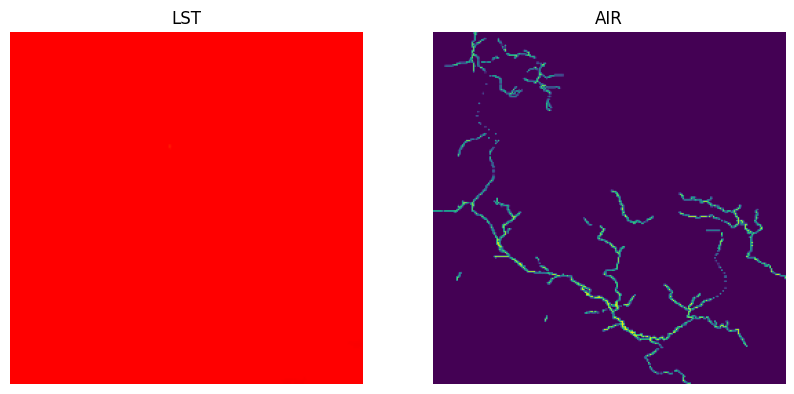

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)

Doing 13
Time slot 2017-07


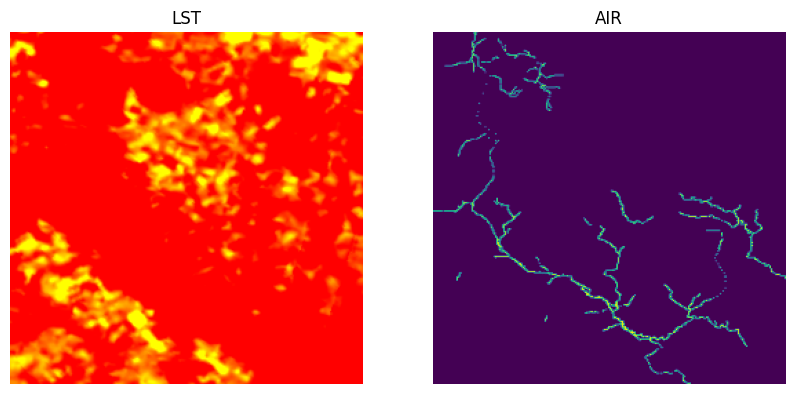

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)

Doing 14
Time slot 2017-12


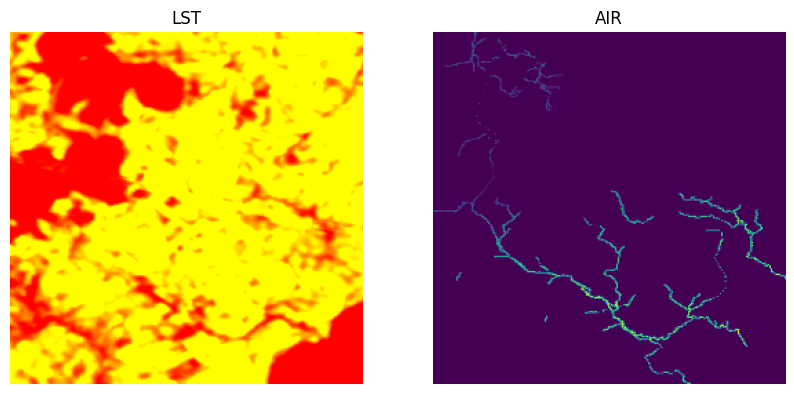

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)

Doing 15
Time slot 2018-05


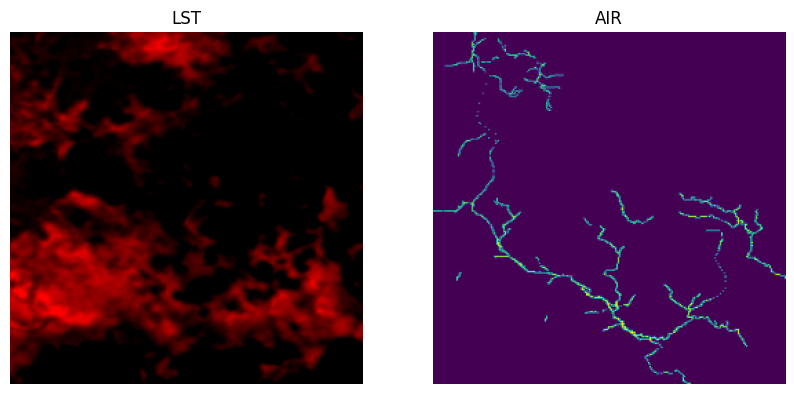

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)

Doing 16
Time slot 2018-10


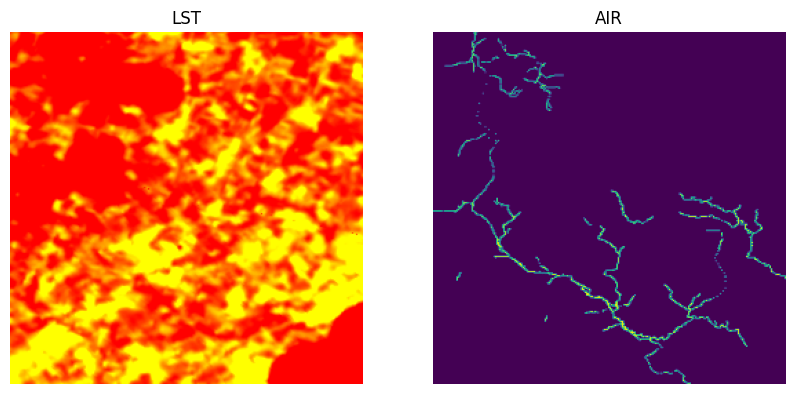

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)

Doing 17
Time slot 2019-02


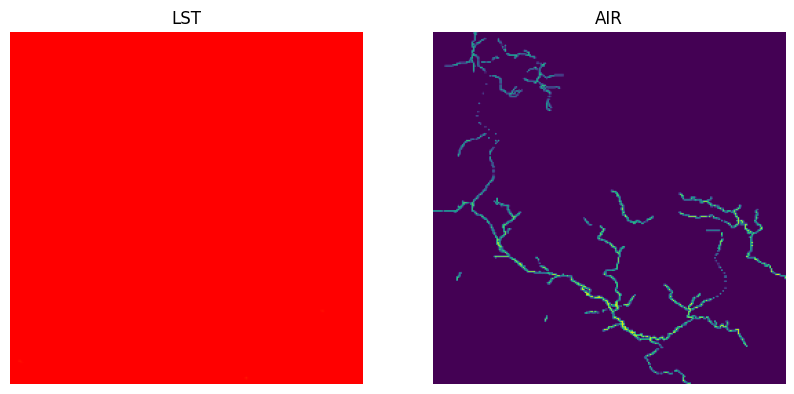

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)



In [72]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming lst_data and airtemp_data are lists of arrays
for i,(img_data, airtemp_dat) in enumerate(zip(lst_data, airtemp_data_filt)):
    print('Doing',i)
    print('Time slot', time_slots[0][i])
    # Create a figure with two subplots (1 row, 2 columns)
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # Adjust the figure size if needed

    # Plot the first image (LST)
    axes[0].imshow(np.clip(img_data * (6/255), 0, 1))
    axes[0].set_title('LST')
    axes[0].axis('off')  # Remove the axis

    # Plot the second image (AIR)
    axes[1].imshow(airtemp_dat)
    axes[1].set_title('AIR')
    axes[1].axis('off')  # Remove the axis

    # Show the images side by side
    plt.show()

    # Optionally, print the shape of the images
    print('LST Shape:', img_data.shape)
    print('AIR Shape:', airtemp_dat.shape)
    print()


#### Filter to obtain only river data

In [73]:
river_mask = airtemp_data[0]  # Cambia el índice según sea necesario

# Imprimir la forma de la imagen seleccionada
print('Selected image shape:', river_mask.shape)

Selected image shape: (256, 256)


In [74]:
river_mask_expanded = np.expand_dims(river_mask, axis=-1)  # Expande para tener forma (height, width, 1)
river_mask_expanded = np.repeat(river_mask_expanded, lst_data.shape[-1], axis=-1)  # Expande a (height, width, 3)

# Aplica la máscara solo a las entradas (inputs)
masked_inputs = []

for input_img in lst_data:
    masked_input = input_img * river_mask_expanded  # Aplica la máscara a los inputs
    masked_inputs.append(masked_input)

# Convierte de nuevo a arrays de numpy
masked_inputs = np.array(masked_inputs)


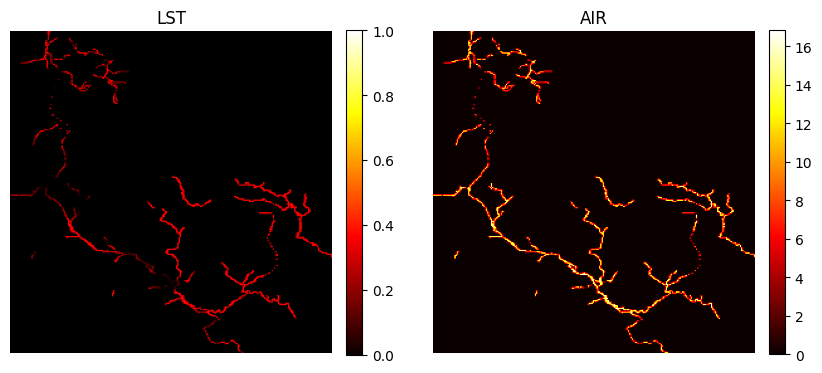

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)



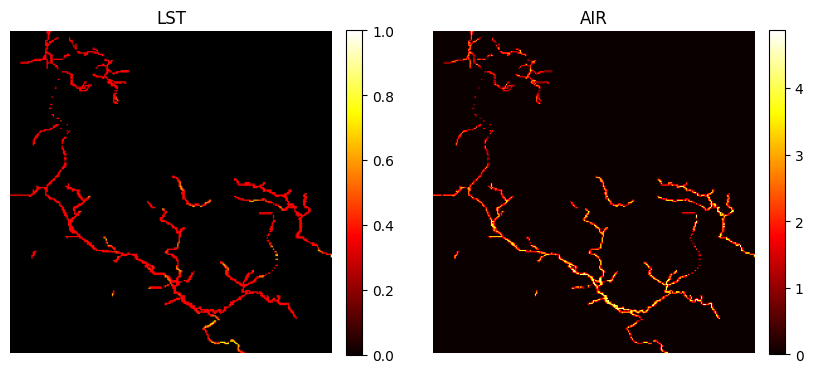

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)



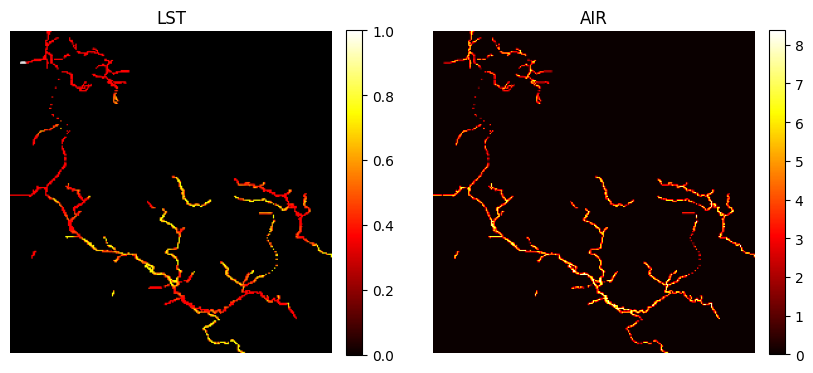

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)



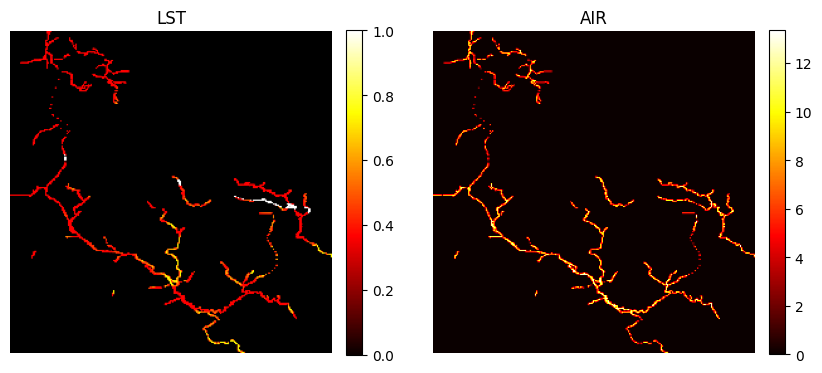

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)



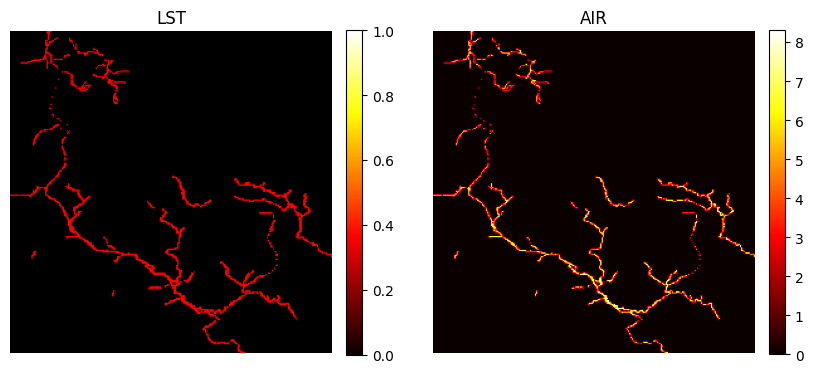

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)



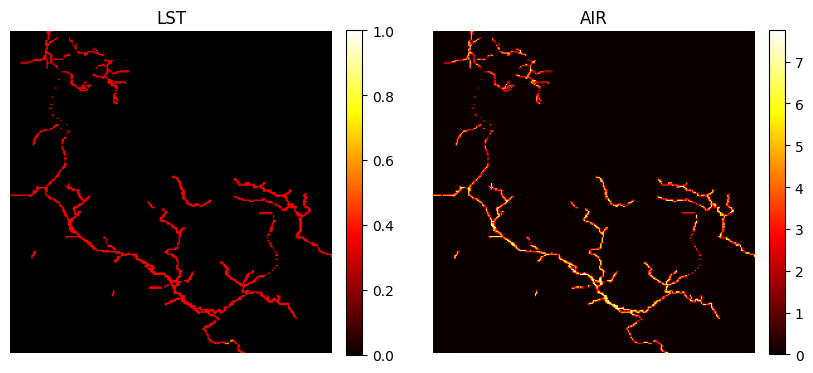

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)



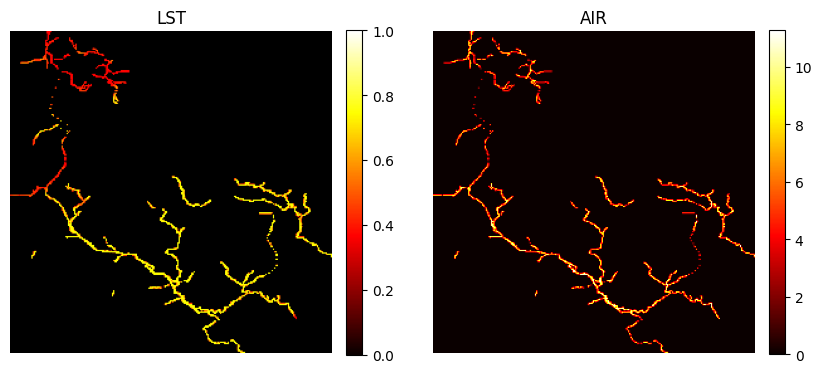

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)



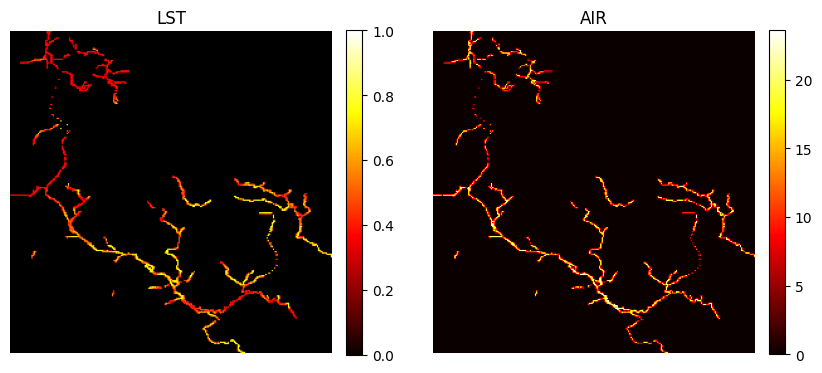

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)



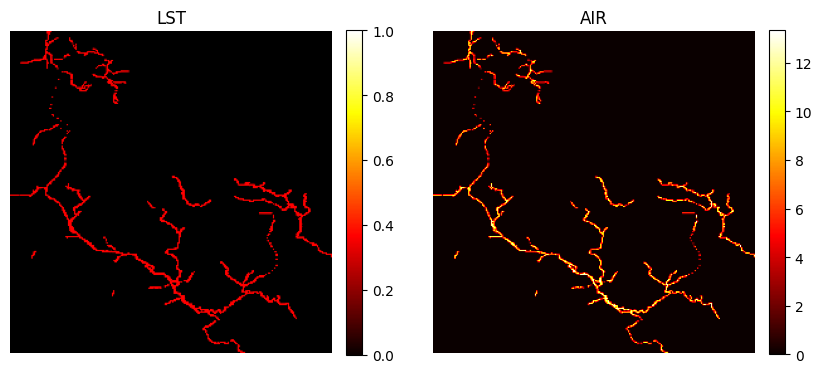

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)



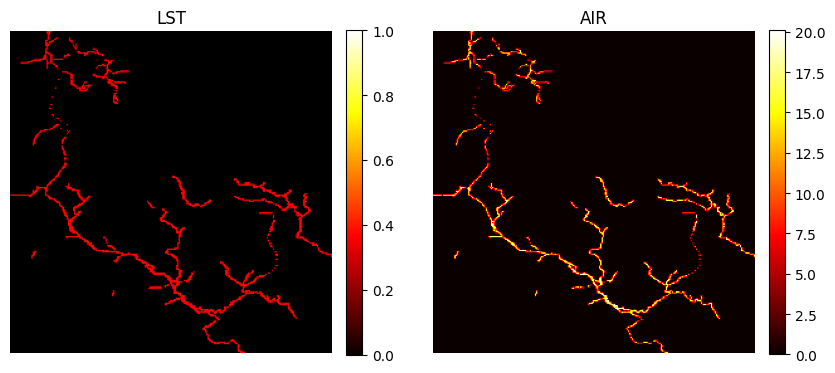

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)



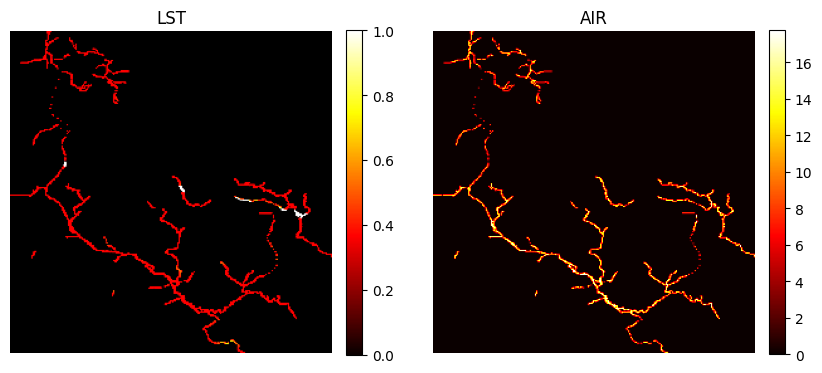

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)



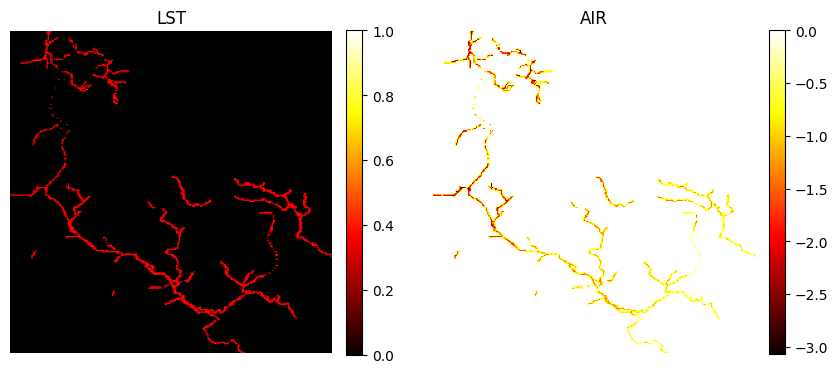

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)



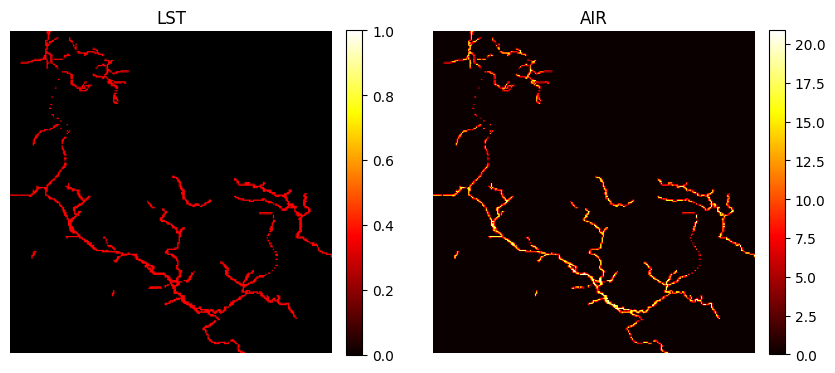

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)



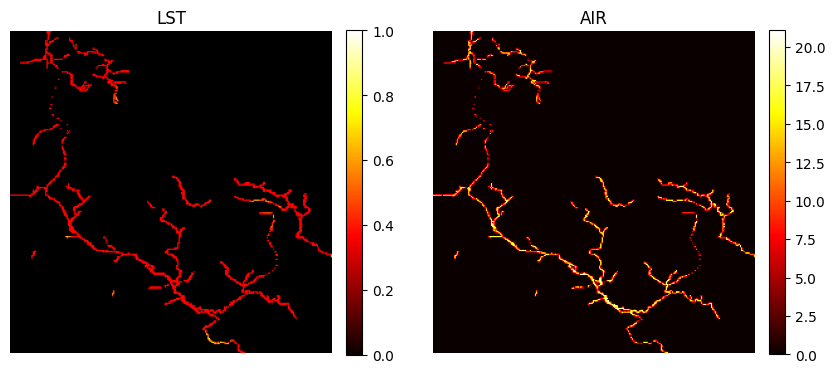

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)



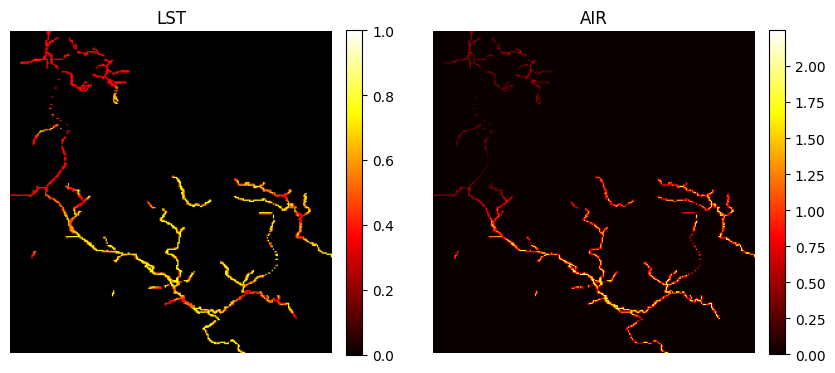

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)



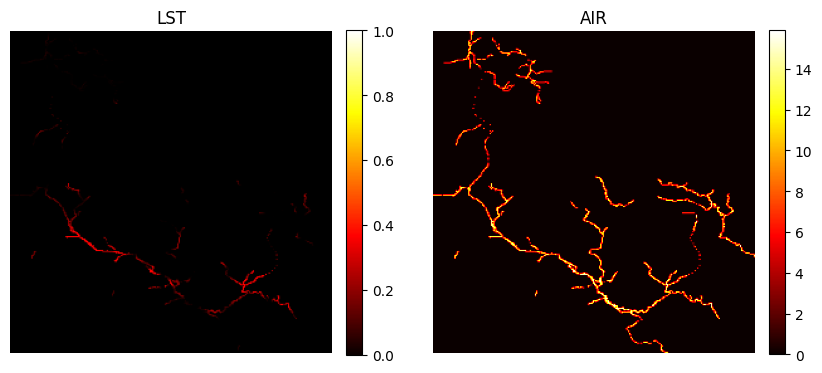

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)



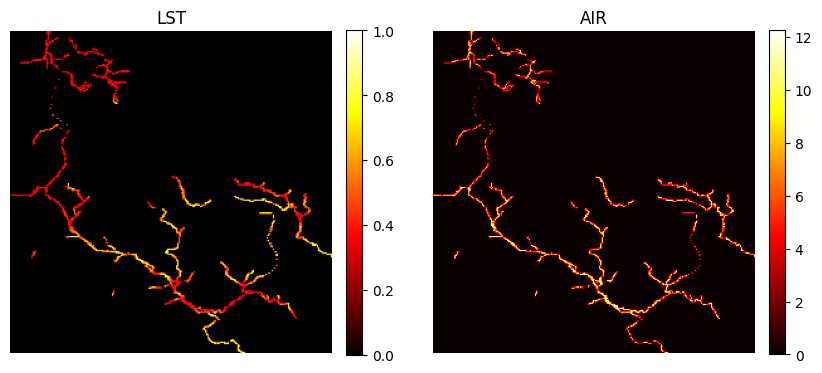

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)



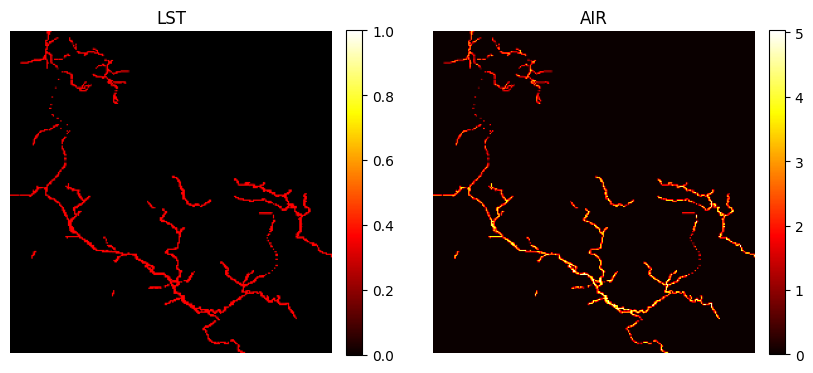

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)



In [75]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming masked_inputs and airtemp_data are lists of arrays
for img_data, airtemp_dat in zip(masked_inputs, airtemp_data_filt):
    # Create a figure with two subplots (1 row, 2 columns)
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # Adjust the figure size if needed

    # Plot the first image (LST)
    img1 = axes[0].imshow(np.clip(img_data * (6/255), 0, 1), cmap='hot')
    axes[0].set_title('LST')
    axes[0].axis('off')  # Remove the axis

    # Add colorbar next to the first subplot
    cbar1 = fig.colorbar(img1, ax=axes[0], orientation='vertical', fraction=0.046, pad=0.04)

    # Plot the second image (AIR)
    img2 = axes[1].imshow(airtemp_dat, cmap='hot')
    axes[1].set_title('AIR')
    axes[1].axis('off')  # Remove the axis

    # Add colorbar next to the second subplot
    cbar2 = fig.colorbar(img2, ax=axes[1], orientation='vertical', fraction=0.046, pad=0.04)

    # Show the images side by side
    plt.show()

    # Optionally, print the shape of the images
    print('LST Shape:', img_data.shape)
    print('AIR Shape:', airtemp_dat.shape)
    print()


In [76]:
airtemp_data_flatten = airtemp_data_filt.reshape(airtemp_data_filt.shape[0], -1)

In [77]:
river_indices = np.nonzero(airtemp_data_filt[0].reshape(-1))[0]
len(river_indices)

4052

In [78]:
filtered_lst = []
filtered_airtemp = []
del_indices = []
for i in range(masked_inputs.shape[0]):
  img_rgb = masked_inputs[i]
  img_gray = np.dot(img_rgb[...,:3], [0.2989, 0.5870, 0.1140]) # turn to gray image, calculate the weighted average of each channel contribution
  river = img_gray.flatten()[river_indices]
  air_filt = airtemp_data_flatten[i][river_indices]
  filtered_lst.append(river)
  filtered_airtemp.append(air_filt)

filtered_lst = np.array(filtered_lst)
filtered_airtemp = np.array(filtered_airtemp)
print(filtered_lst.shape, filtered_airtemp.shape)

(18, 4052) (18, 4052)


In [14]:
temp_1 = filtered_lst[0]
temp_2 = filtered_airtemp[0]
differences = np.array(temp_1) - np.array(temp_2)

plt.plot(differences)
plt.xlabel('Índice de coordenada')
plt.ylabel('Diferencia de temperaturas (Set 1 - Set 2)')
plt.title('Diferencias entre las dos series de temperaturas')
plt.show()

NameError: name 'filtered_lst' is not defined

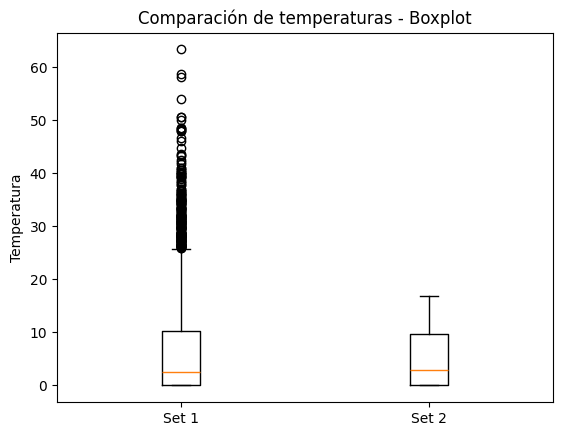

In [80]:
plt.boxplot([temp_1, temp_2], labels=['Set 1', 'Set 2'])
plt.ylabel('Temperatura')
plt.title('Comparación de temperaturas - Boxplot')
plt.show()


#### Plot KDE

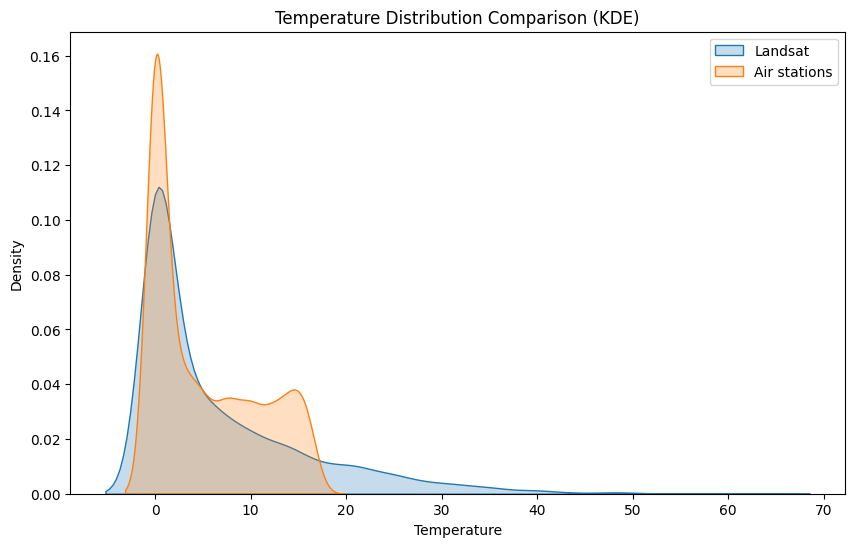

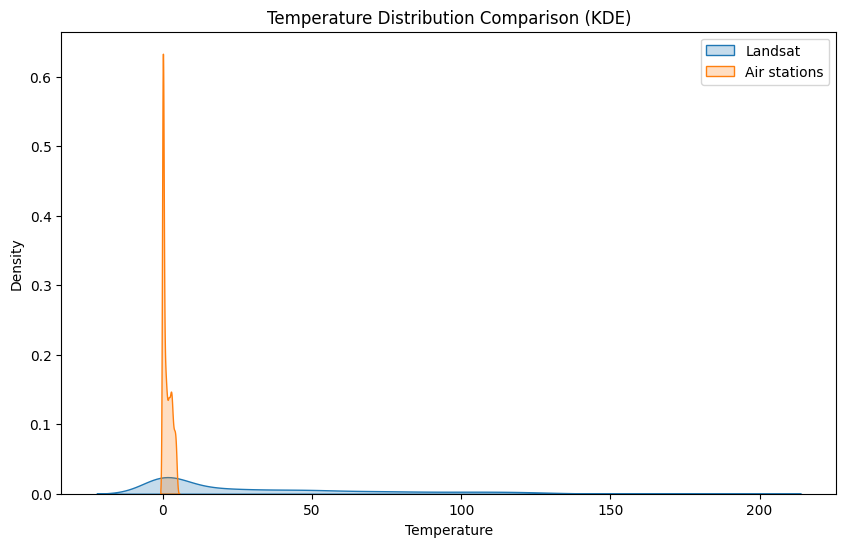

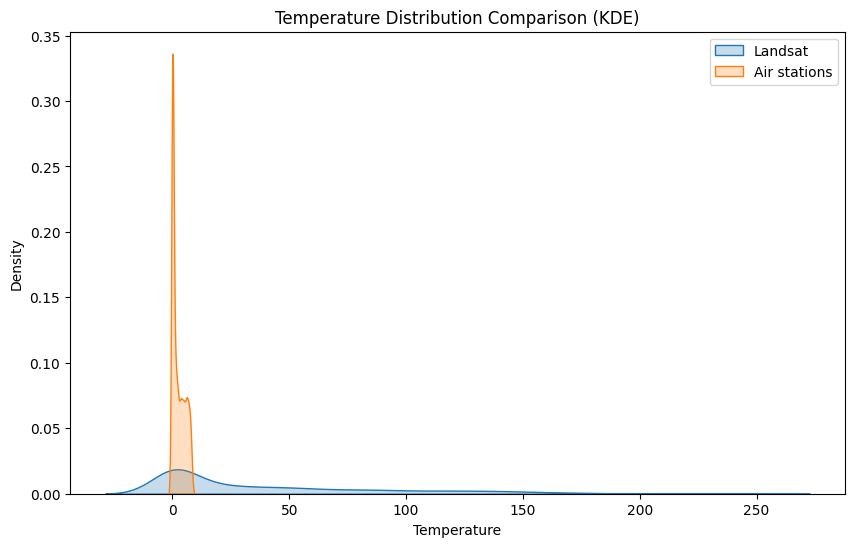

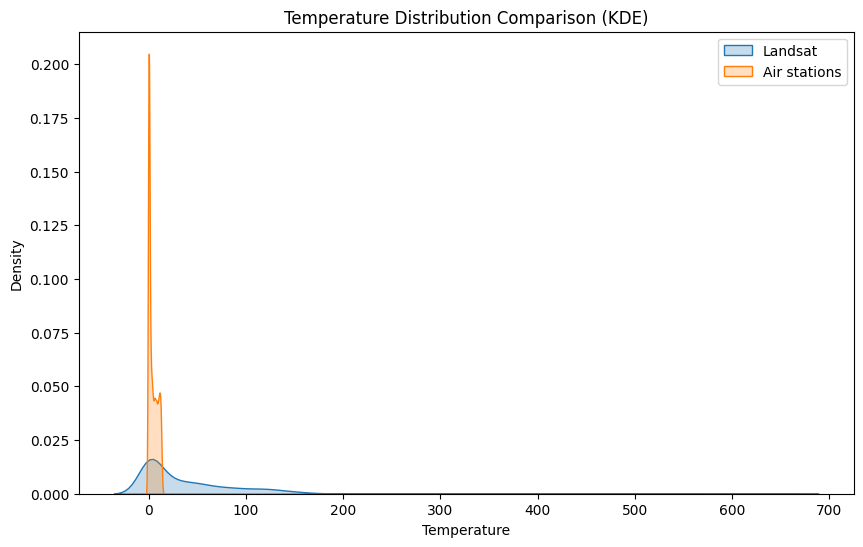

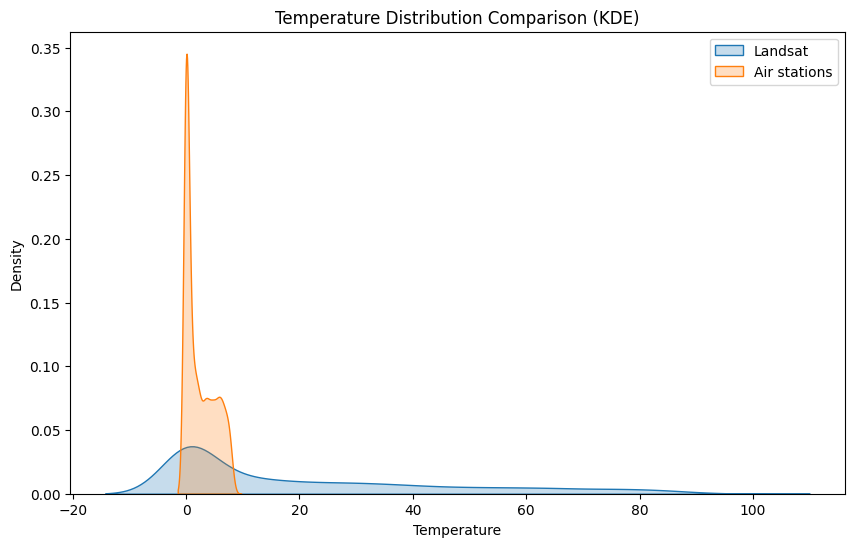

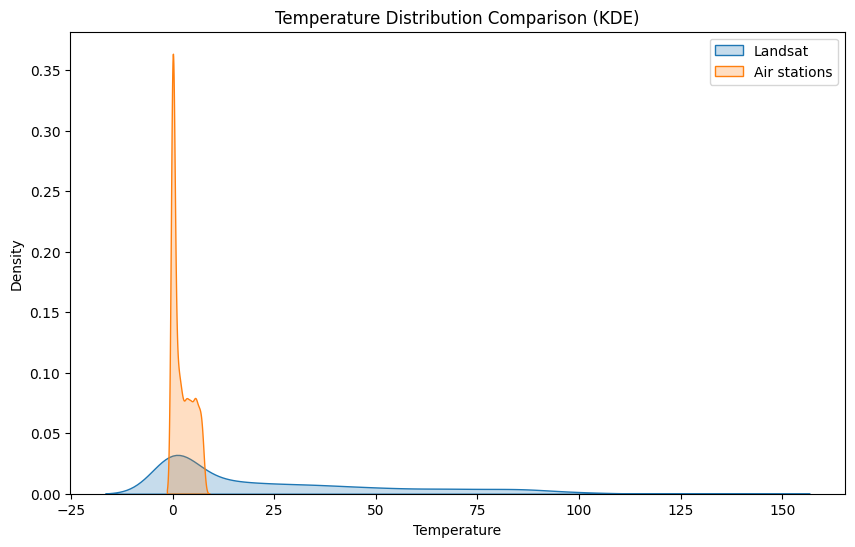

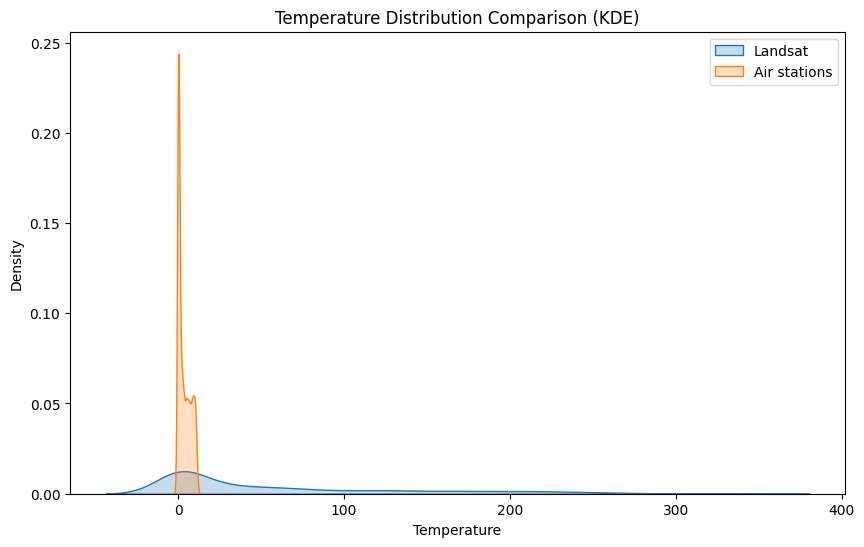

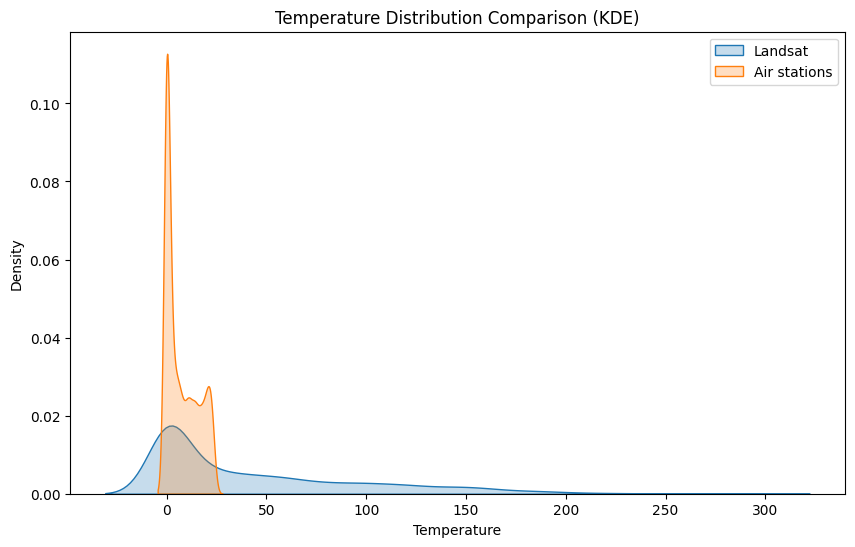

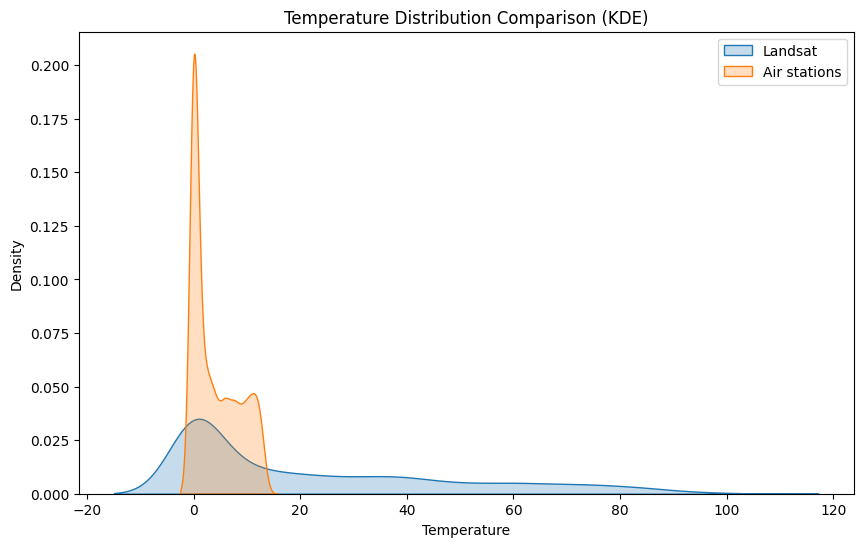

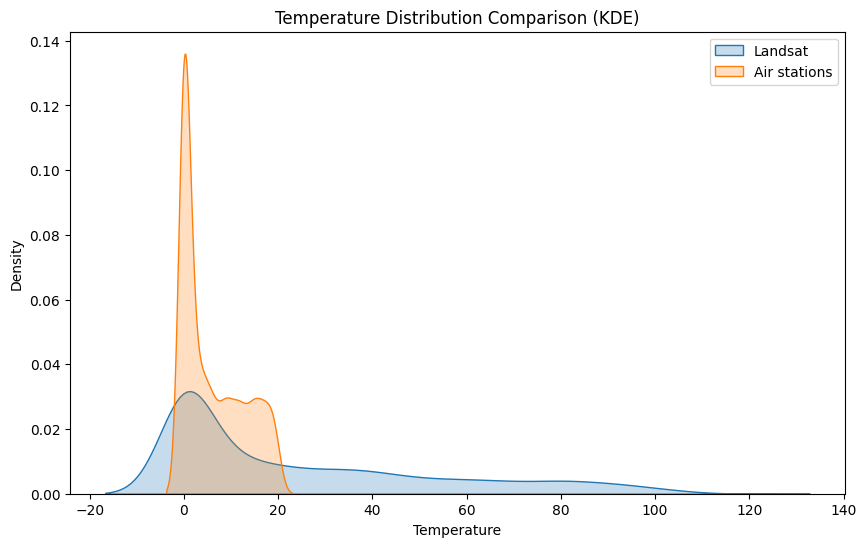

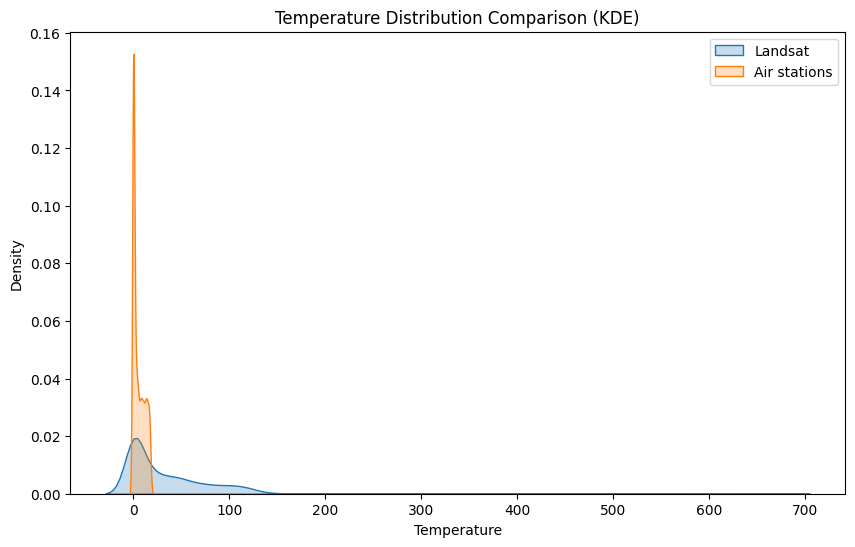

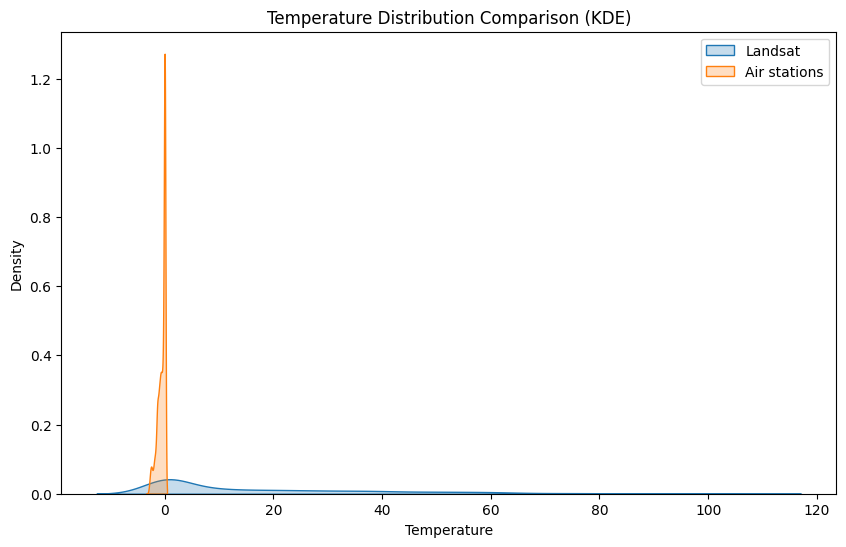

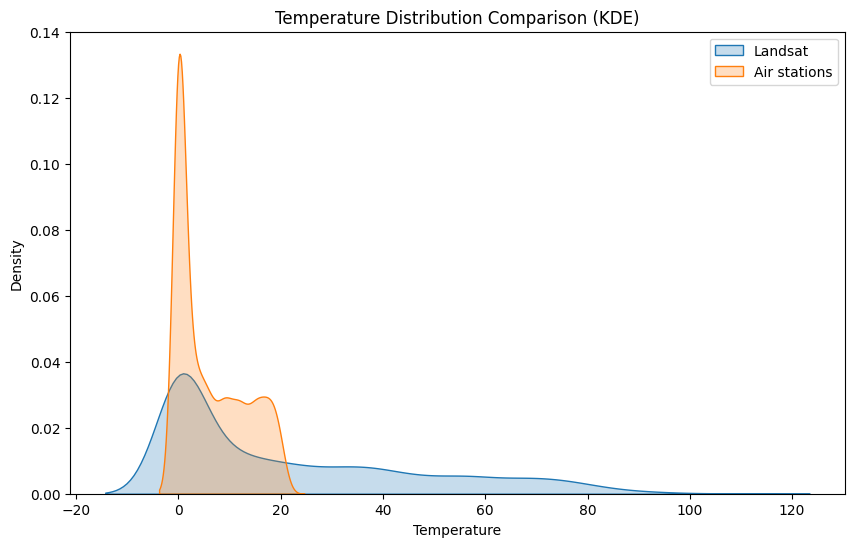

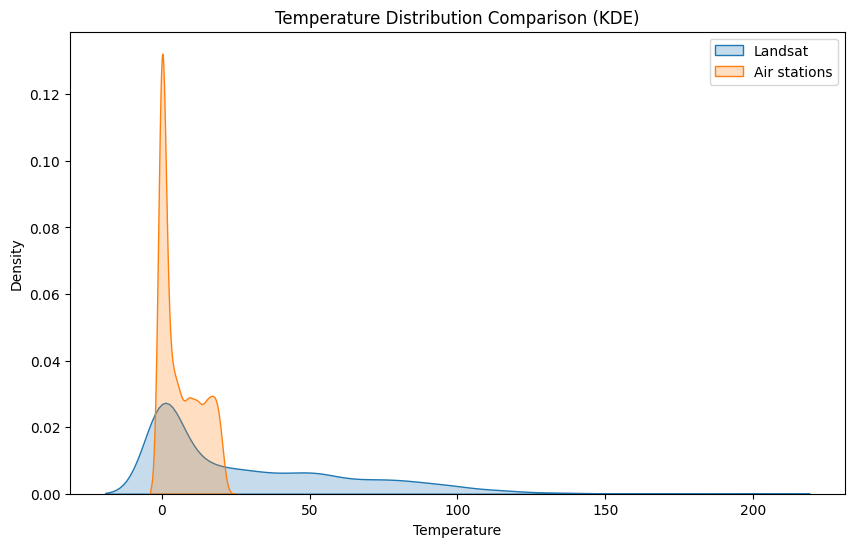

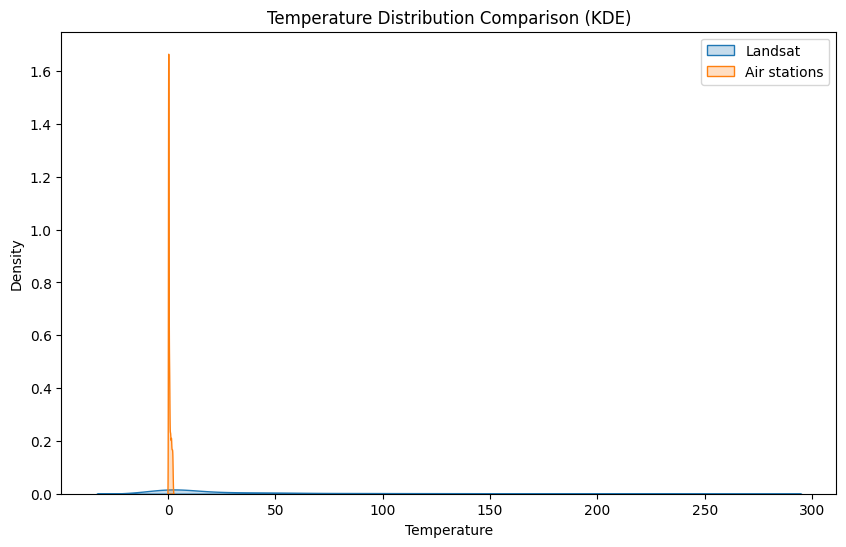

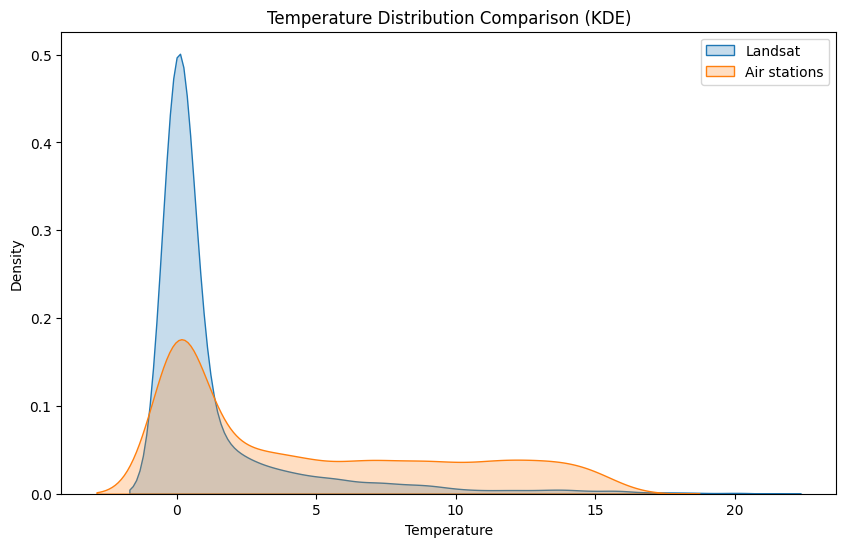

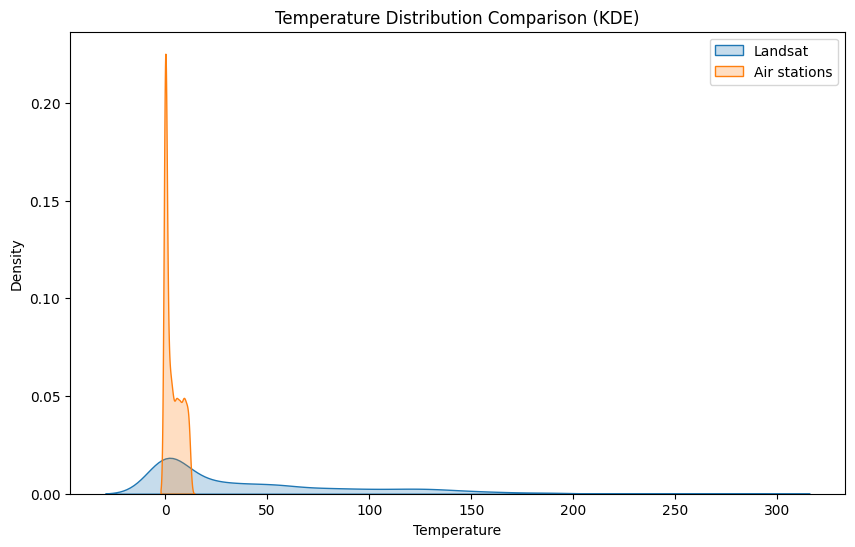

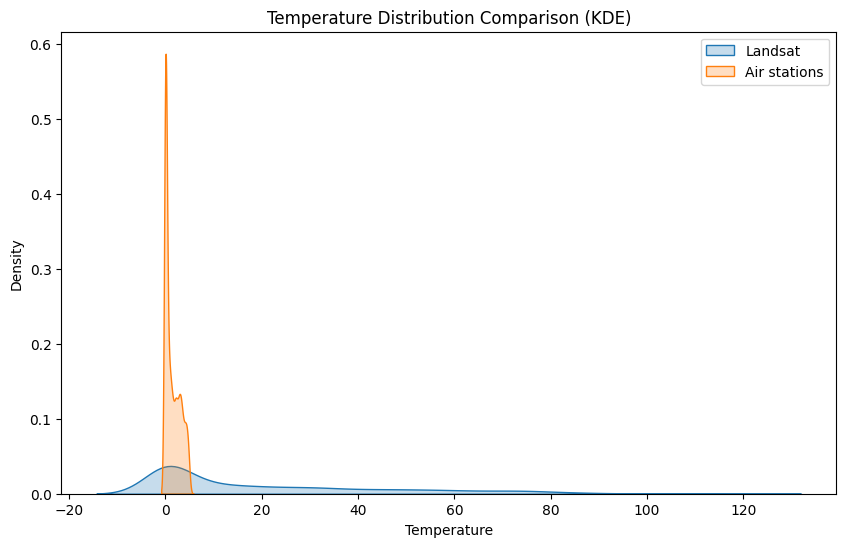

In [83]:
import seaborn as sns
p_values = {}
for i in range(filtered_lst.shape[0]):
  # Example temperature arrays
  temperature_array1 = filtered_lst[i]
  temperature_array2 = filtered_airtemp[i]

  # Plot KDE for both temperature arrays
  plt.figure(figsize=(10, 6))
  sns.kdeplot(temperature_array1, label='Landsat', fill=True)
  sns.kdeplot(temperature_array2, label='Air stations', fill=True)

  # Customize the plot
  plt.title('Temperature Distribution Comparison (KDE)')
  plt.xlabel('Temperature')
  plt.ylabel('Density')
  plt.legend(loc='upper right')
  plt.show()

  stat, p_value = ks_2samp(temperature_array1, temperature_array2)
  mse = mean_squared_error(temperature_array1, temperature_array2)
  rmse = np.sqrt(mse)


  p_values[i] = [p_value,rmse]


In [84]:
pd.DataFrame(p_values,index=['ks p_value', 'RMSE'])

0          1          2          3          4   \
ks p_value  3.851751e-34   0.000000   0.000000   0.000000   0.000000   
RMSE        6.108918e+00  48.998924  61.810872  70.166529  29.305466   

                   5          6          7          8              9   \
ks p_value   0.000000   0.000000   0.000000   0.000000  2.231813e-318   
RMSE        34.703398  94.480685  59.700468  28.869065   2.984840e+01   

                  10         11             12         13         14  \
ks p_value   0.00000   0.000000  1.413132e-280   0.000000   0.000000   
RMSE        55.03612  29.565759   2.442104e+01  35.341396  74.713813   

                       15         16         17  
ks p_value  1.106535e-224   0.000000   0.000000  
RMSE         5.429611e+00  61.271802  30.766186

#### Pixel wise difference

Mean Squared Error: 6.733331785699782


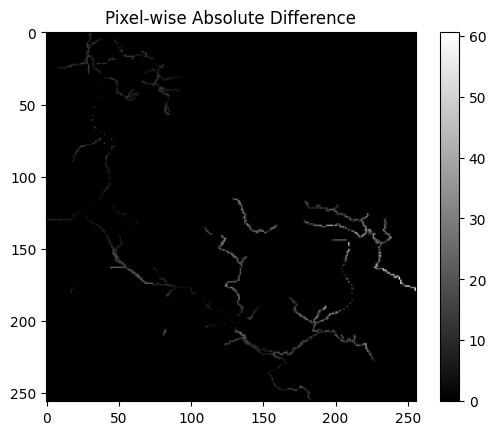

Mean Squared Error: 150.75635000030857


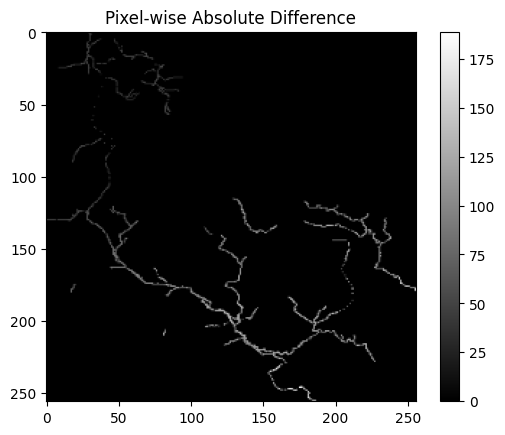

Mean Squared Error: 237.42063236042537


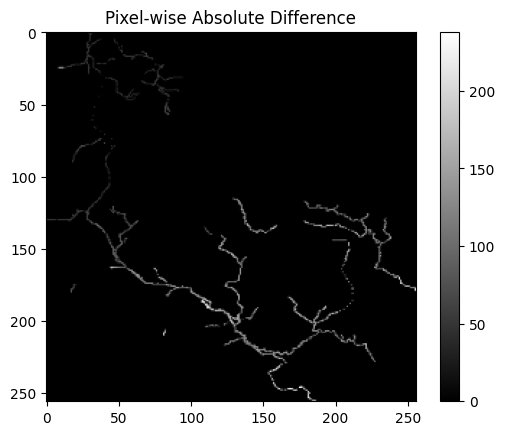

Mean Squared Error: 302.6138944369619


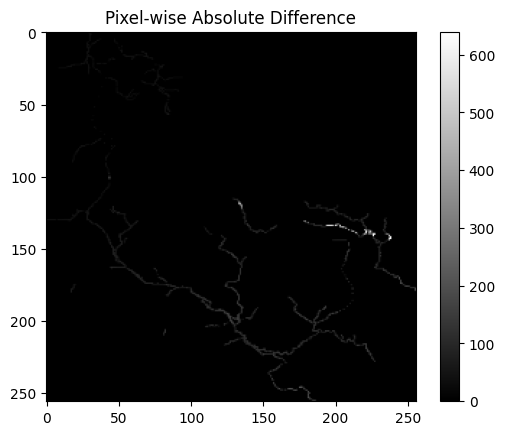

Mean Squared Error: 40.855617530431005


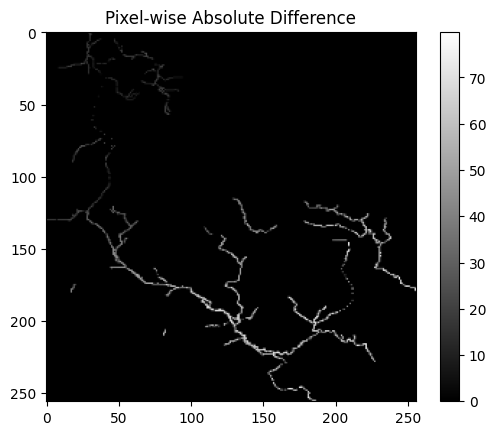

Mean Squared Error: 56.93202828405902


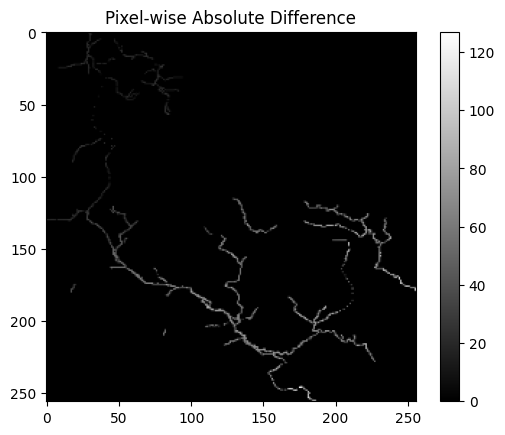

Mean Squared Error: 520.3913616712338


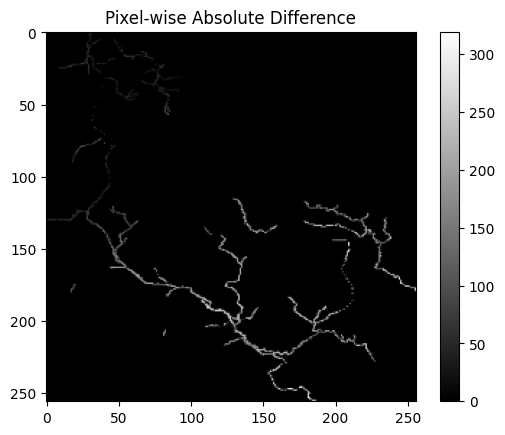

Mean Squared Error: 231.4280786812838


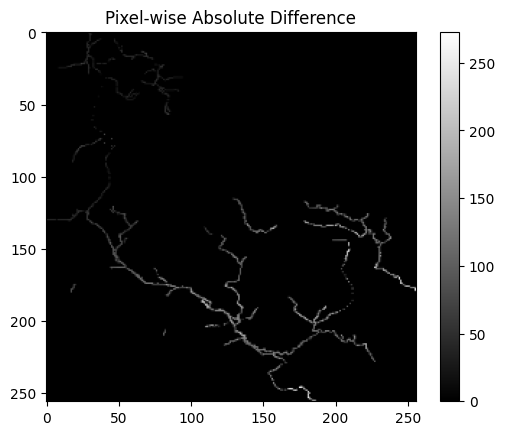

Mean Squared Error: 44.714326664288144


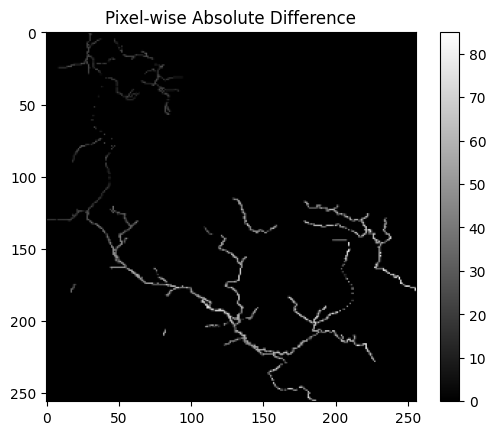

Mean Squared Error: 69.70859624887373


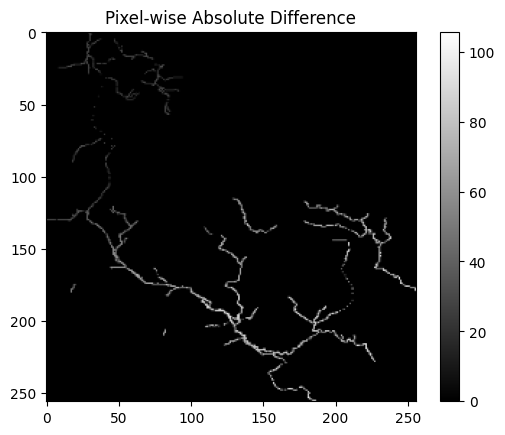

Mean Squared Error: 214.89220728362938


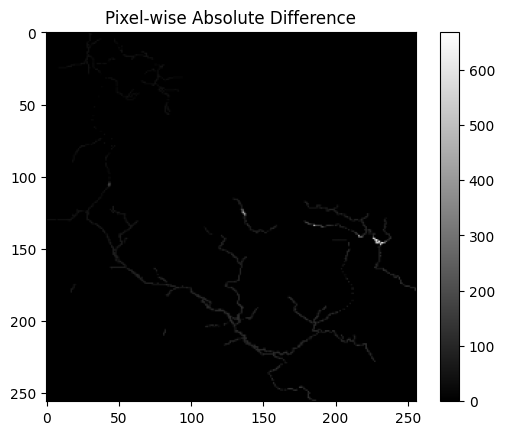

Mean Squared Error: 45.088402815266846


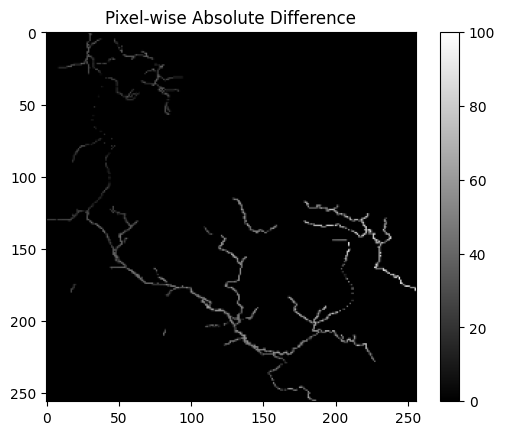

Mean Squared Error: 62.700762249980514


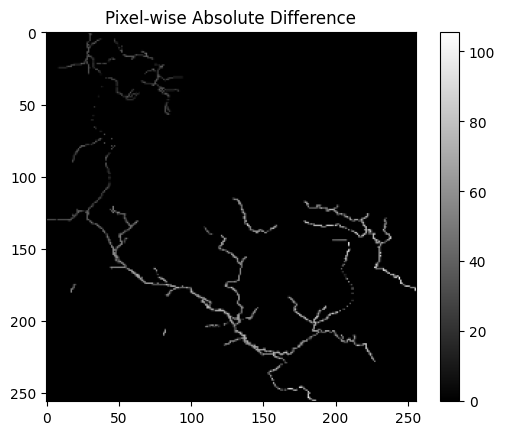

Mean Squared Error: 125.5799180921349


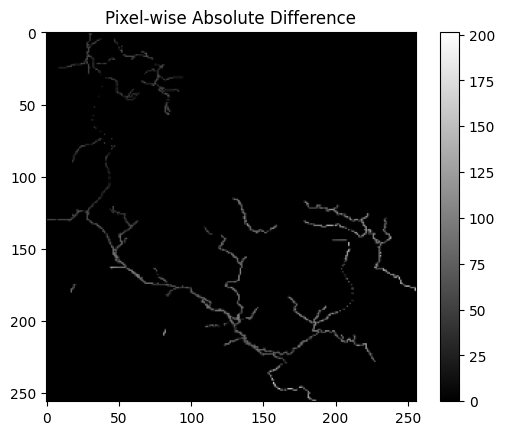

Mean Squared Error: 315.4947180834147


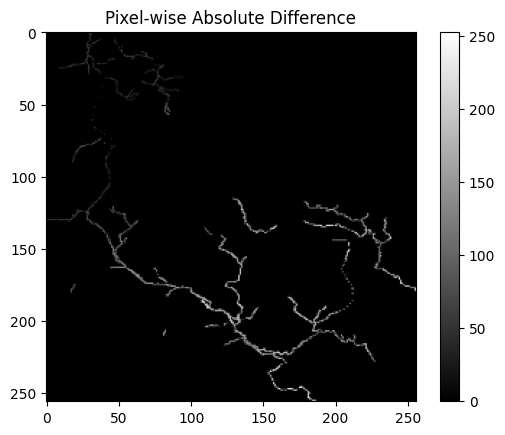

Mean Squared Error: 0.7131724439868378


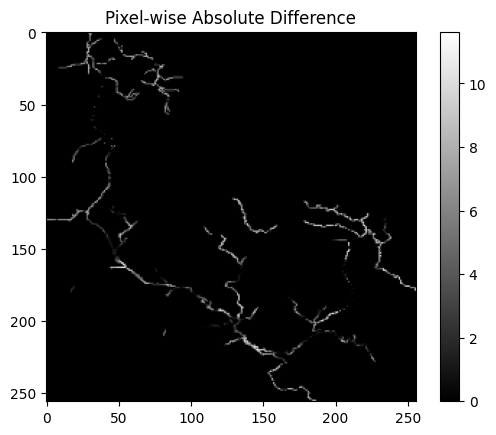

Mean Squared Error: 222.6432575049457


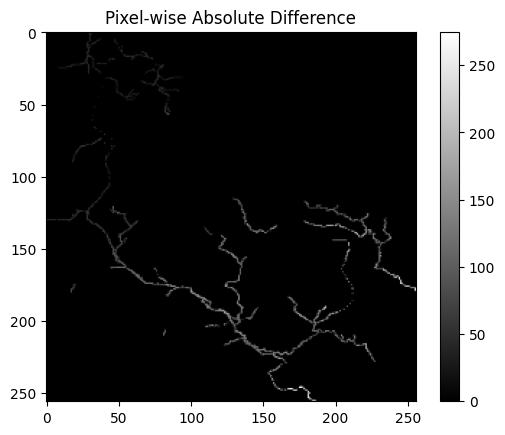

Mean Squared Error: 38.25658127062545


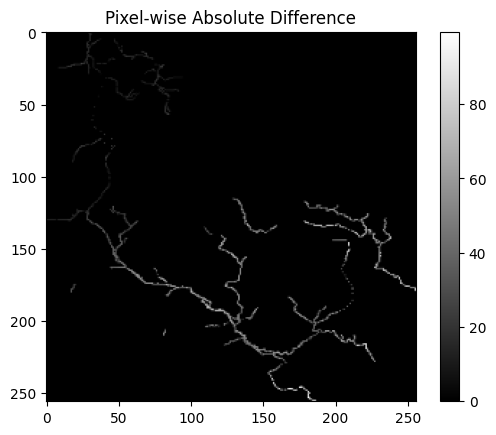

In [85]:
import cv2  # OpenCV for histogram calculation
import matplotlib.pyplot as plt

def mse(imageA, imageB):
    # Compute the Mean Squared Error between the two images
    return np.mean((imageA - imageB) ** 2)

for img_data, airtemp_dat in zip(masked_inputs, airtemp_data):
  img_gray = np.dot(img_data[...,:3], [0.2989, 0.5870, 0.1140]) # turn to gray image, calculate the weighted average of each channel contribution
  absolute_difference = np.abs(img_gray - airtemp_dat)

  img1 = img_gray
  img2 = airtemp_dat

  # Display the result
  mse_value = mse(img1, img2)
  print("Mean Squared Error:", mse_value)

  plt.imshow(absolute_difference, cmap='gray')
  plt.title("Pixel-wise Absolute Difference")
  plt.colorbar()
  plt.show()


In [86]:
mediana_lst = np.median(filtered_lst, axis=1)

mediana_air = np.median(filtered_airtemp, axis=1)
print(mediana_lst.shape,mediana_air.shape)

(18,) (18,)


In [87]:
plt.figure(figsize=(10,6))
# Plot df1
plt.plot(period_filt, mediana_lst, label='Temperature Landsat', marker='o')

# Plot df2
plt.plot(period_filt, mediana_air, label='Temperature interpolation', marker='o')

# Customize the plot
plt.title('Temperature Evolution Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

NameError: name 'period_filt' is not defined

<Figure size 1000x600 with 0 Axes>

## Correlation analysis

In [3]:
source_dir = '../data/preprocessed'
data = ['lst','wt','ndvi']
all_ds = {k: [] for k in data}
for d in data:
    source_path = os.path.join(source_dir,d)
    for subdir, dirs, files in os.walk(source_path):
        for file in files:
            if file.endswith('.csv'):
                all_ds[d].append(pd.read_csv(f'{subdir}/{file}',index_col=0))

In [17]:
from scipy.stats import pearsonr

for river in range(3):
    for i,row in all_ds['lst'][river].iterrows():
        corr_temp_ndvi, _ = pearsonr(all_ds['lst'][river].loc[i].values, all_ds['ndvi'][river].loc[i])
        corr_temp_water, _ = pearsonr(all_ds['lst'][river].loc[i], all_ds['wt'][river].loc[i])
        corr_ndvi_water, _ = pearsonr(all_ds['ndvi'][river].loc[i], all_ds['wt'][river].loc[i])

    print('River:', river)
    print("Correlation between LST and NDVI:", corr_temp_ndvi)
    print("Correlation between LST and water temperature:", corr_temp_water)
    print("Correlation between NDVI and water temperature:", corr_ndvi_water)

River: 0
Correlation between LST and NDVI: 0.09369590400203456
Correlation between LST and water temperature: 0.10318637820521265
Correlation between NDVI and water temperature: -0.19989918266097859
River: 1
Correlation between LST and NDVI: 0.6298770778048457
Correlation between LST and water temperature: -0.0008903574843250718
Correlation between NDVI and water temperature: 0.025075045232433705
River: 2
Correlation between LST and NDVI: 0.33339987965391177
Correlation between LST and water temperature: -0.0011519095433006974
Correlation between NDVI and water temperature: -0.14107705971153217
